# Simulation of HTE-like data

In [574]:
# libraries
library(tidyverse)
library(caret)
library(ggprism)
library(gtools)
library(patchwork)
library(scales)

# parallel registration
library(doParallel)
cl <- makePSOCKcluster(detectCores() - 1)
registerDoParallel(cl)

## select some colours from a palette
agd_palette <- c("#0063C3", "#00BCD0", "#CB7C85", "#E8C9BB", "#252A5A",
                  "#7D2C42", "#A9A9A9")

In [516]:
# Analytical function to model
func <- function(x) sin(2 * 3.14 * x - 3.14)

# data to plot the function if needed
func_data <- data.frame(x = seq(0, 1, length = 501)) %>% mutate(y = func(x))

In [517]:
make_data <- function(scenario, n_sub, n_extra_var, noise_sd, ratio) {

    # generate substrate features
    extra_features <- matrix(runif(n_sub * n_extra_var), ncol = n_extra_var)
    colnames(extra_features) <- paste("extra_var", 1:n_extra_var, sep = "_")
    sub <- cbind(data.frame(var = runif(n_sub)), extra_features)

    if (scenario == "0") {
        # main effect only, no conditions
        data <- rbind(sub %>% mutate(cond = "A", target = func(var)),
                     sub %>% mutate(cond = "B", target = func(var)))
    } else if (scenario == "1") {
        # main effect, non-interacting conditions
        data <- rbind(sub %>% mutate(cond = "A",
          target = ratio * (runif(n_sub) - 0.5)),
         sub %>% mutate(cond = "B",
          target = ratio * (runif(n_sub) - 0.5) + 0.5 * func(var)),
          sub %>% mutate(cond = "C",
          target = ratio * (runif(n_sub) - 0.5) - var + 0.5)
                    )
    } else if (scenario == "2") {
        # interaction conditions
        main <- ratio * (runif(n_sub) - 0.5)
        data <- rbind(sub %>% mutate(cond = "A", target = main),
                sub %>% mutate(cond = "B", target = main + 0.5 * func(var)),
                sub %>% mutate(cond = "C", target = main - var + 0.5)
                    )
    } else {
        print("unsuporrted scenario")
    }

    data <- data %>%
        rowwise() %>%
        mutate(target = target + rnorm(1, sd = noise_sd)) %>%
        as.data.frame()
}

In [518]:
# helper function to fetch a subset of data including additional features
fetch_data <- function(data, n_extra_vars) {
    extra_data <- data %>% select(contains("extra")) %>% select(0:n_extra_vars)
    reg_data <- data %>%
        select(var, target, cond) %>%
        mutate(cond = as.factor(cond))
    cbind(reg_data, extra_data)
}

In [529]:
linetype_pal()(3)

[1] "solid" "22"    "42"

In [575]:
t <- make_data("2", 30, 50, 0, 1)

# plot training data
options(repr.plot.width = 6, repr.plot.height = 4)

p1 <- t %>%
 filter(cond == "A") %>%
ggplot(aes(x = var, y = target, color = cond)) +
    geom_point(size = 1) +
    geom_line(aes(linetype = cond)) +
    scale_color_manual(values = agd_palette) +
    labs(color = "Solvent", linetype = "Solvent",
         y = expression(Yield[A]), x = expression(mu)) +
    theme_prism(base_size = 6.3) +
    theme(text = element_text(face = "plain", family = "sans")) +
    guides(col = "none", linetype = "none")


p2 <- t %>%
    pivot_wider(id_cols = var, values_from = target, names_from = cond) %>%
    mutate("B" = B - A, "C" = C - A) %>%
    select(var, "B", "C") %>%
    pivot_longer(cols = c("B", "C")) %>%
ggplot(aes(x = var, y = value, color = factor(name))) +
    geom_point(size = 1) +
    geom_line(aes(linetype = factor(name))) +
    scale_color_manual(values = agd_palette[c(2, 3)]) +
    scale_linetype_manual(values = linetype_pal()(3)[c(2, 3)]) +
    labs(color = "Solvent", linetype = "Solvent",
         y = expression(Yield - Yield[A]), x = expression(mu)) +
    theme_prism(base_size = 6.3) +
    theme(text = element_text(face = "plain", family = "sans")) +
    guides(col = "none", linetype = "none")


p3 <- t %>%
ggplot(aes(x = var, y = target, col = factor(cond))) +
    geom_line(aes(linetype = factor(cond))) +
    geom_point(size = 1) +
    scale_color_manual(values = agd_palette) +
    scale_linetype_manual(values = linetype_pal()(3)) +
    labs(col = "Solvent", linetype = "Solvent",
         y = expression(Yield), x = expression(mu)) +
    theme_prism(base_size = 6.3) +
    theme(legend.key.width = unit(1.9, "line")) +
    theme(legend.position = "top", legend.title = element_text(),
          text = element_text(face = "plain", family = "sans"))

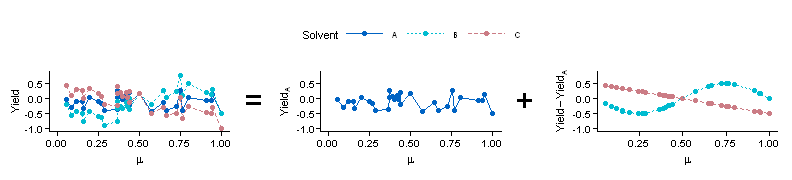

In [576]:
options(repr.plot.width = 6.6, repr.plot.height = 1.5)
pf1 <- (((p3 +
 theme(plot.margin = margin(r = 0.4, unit = "in")) +
 annotate("text", label = "=", x = 1.2, y = 0, size = 7) +
 coord_cartesian(xlim = c(0, 1), clip = "off")) |
(p1 +
 theme(plot.margin = margin(r = 0.4, unit = "in")) +
 annotate("text", label = "+", x = 1.2, y = 0, size = 7) +
 coord_cartesian(xlim = c(0, 1), clip = "off")) |
 p2) & ylim(c(-1, 0.8))) + plot_layout(guides = "collect") & theme(legend.position = "top")
 
pf1 

ggsave("../doexyF_paper/plots/simulation_A.png",
 pf1, width = 6.6, height = (1 / 4) * 6.76, dpi = 600)
ggsave("../doexyF_paper/plots/simulation_A.svg",
 pf1, width = 6.6, height = (1 / 4) * 6.76)

In [369]:
# constants
ctrl <- trainControl(method = "lgocv", p = 0.7, number = 10)
xgb_grid <- expand.grid(nrounds = c(1, 2, 3, 5),  max_depth = 6,  eta = 0.3,
    gamma = 0,  colsample_bytree = 1,  min_child_weight = 1,  subsample = 1)

ps <- c(0, 1, 3, 5, 10, 20, 30, 40, 50)
ratios <- c(0.1, 0.5, 1, 2)
n_subs <- c(10, 20, 30, 40, 50)
repeats <- 30

In [43]:
tot_tr <- data.frame()
tot_val <- data.frame()
results <- data.frame()

for (ratio in ratios) {
    for (n in n_subs) {
        for (i in 1:repeats) {

            t <- make_data("2", n, 50, 0, ratio)
            v <- make_data("2", 100, 50, 0, ratio)

            v.diff <- v %>%
              pivot_wider(id_cols = var, values_from = target,
               names_from = cond) %>%
                        mutate(ba = B - A, ca = C - A) %>%
                        select(var, ba, ca) %>%
                        pivot_longer(cols = c(ba, ca))

            for (p in ps) {
                print(c(ratio, n, i, p))

                tr_data <- fetch_data(t, p)
                val_data <- fetch_data(v, p)

                model.rf <- train(target ~ ., data = tr_data, ntree = 50,
                 trControl = ctrl, tuneLength = 5)
                model.xgb <- train(target ~ ., data = tr_data,
                 trControl = ctrl, tuneGrid = xgb_grid, method = "xgbTree")
                model.knn <- train(target ~., data = tr_data,
                 trControl = ctrl, tuneLength = 5, method = "knn")

                pred.rf <- predict(model.rf, val_data)
                pred.xgb <- predict(model.xgb, val_data)
                pred.knn <- predict(model.knn, val_data)

                p.diff.rf <- val_data %>%
                 mutate(pred = pred.rf) %>%
                 pivot_wider(id_cols = var, values_from = pred,
                  names_from = cond) %>%
                 mutate(ba = B - A, ca = C - A) %>%
                 select(var, ba, ca) %>%
                 pivot_longer(cols = c(ba, ca))

                p.diff.xgb <- val_data %>%
                 mutate(pred = pred.xgb) %>%
                 pivot_wider(id_cols = var, values_from = pred,
                  names_from = cond) %>%
                 mutate(ba = B - A, ca = C - A) %>%
                 select(var, ba, ca) %>%
                 pivot_longer(cols = c(ba, ca))

                p.diff.knn <- val_data %>%
                 mutate(pred = pred.knn) %>%
                 pivot_wider(id_cols = var, values_from = pred,
                  names_from = cond) %>%
                 mutate(ba = B - A, ca = C - A) %>%
                 select(var, ba, ca) %>%
                 pivot_longer(cols = c(ba, ca))

                tot.rf <- merge(p.diff.rf, v.diff, by = c("var", "name"))
                tot.xgb <- merge(p.diff.xgb, v.diff, by = c("var", "name"))
                tot.knn <- merge(p.diff.knn, v.diff, by = c("var", "name"))

                ret.rf <- postResample(tot.rf$value.x, tot.rf$value.y)
                ret.xgb <- postResample(tot.xgb$value.x, tot.xgb$value.y)
                ret.knn <- postResample(tot.knn$value.x, tot.knn$value.y)

                results <- rbind(results,
                 data.frame(t(ret.rf)) %>%
                  mutate(model = "rf", n_extra = p, n_sub = n,
                   repetition = i, ratio = ratio),
                 data.frame(t(ret.xgb)) %>%
                  mutate(model = "xgb", n_extra = p, n_sub = n,
                   repetition = i, ratio = ratio),
                 data.frame(t(ret.knn)) %>%
                  mutate(model = "knn", n_extra = p, n_sub = n,
                   repetition = i, ratio = ratio))

                tot_tr <- rbind(tot_tr,
                 tr_data %>%
                 select(var, cond, target) %>%
                 mutate(type = "training", n_extra = p, n_sub = n,
                  repetition = i, ratio = ratio))
                tot_val <- rbind(tot_val,
                 val_data %>%
                 mutate(pred.rf = pred.rf, pred.xgb = pred.xgb,
                  pred.knn = pred.knn) %>%
                select(var, cond, target, pred.rf, pred.xgb, pred.knn) %>%
                mutate(type = "validation", n_extra = p, n_sub = n,
                 repetition = i, ratio = ratio))

            }
        }
    }
}

[1]  0.1 10.0  1.0  0.0


Note: Using an external vector in selections is ambiguous.
i Use `all_of(n_extra_vars)` instead of `n_extra_vars` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  1.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0 20.0
[1]  0.1 10.0  2.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  2.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  3.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 10.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  4.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  4.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  4.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  4.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  4.0 30.0
[1]  0.1 10.0  4.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  4.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0 20.0
[1]  0.1 10.0  5.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  5.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 10.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  6.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  6.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  6.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  6.0 20.0
[1]  0.1 10.0  6.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  6.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  6.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 10.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 10.0  7.0  3.0
[1]  0.1 10.0  7.0  5.0
[1]  0.1 10.0  7.0 10.0
[1]  0.1 10.0  7.0 20.0
[1]  0.1 10.0  7.0 30.0
[1]  0.1 10.0  7.0 40.0
[1]  0.1 10.0  7.0 50.0
[1]  0.1 10.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  8.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0  9.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 10.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 10.0  5.0
[1]  0.1 10.0 10.0 10.0
[1]  0.1 10.0 10.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 10.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 10.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 10.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0  5.0
[1]  0.1 10.0 11.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 11.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 12.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 12.0  5.0
[1]  0.1 10.0 12.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 12.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 12.0 30.0
[1]  0.1 10.0 12.0 40.0
[1]  0.1 10.0 12.0 50.0
[1]  0.1 10.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 13.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 13.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 13.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 13.0 20.0
[1]  0.1 10.0 13.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 13.0 40.0
[1]  0.1 10.0 13.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 14.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 15.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 16.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 17.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 18.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 19.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 20.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 20.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 20.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 20.0 20.0
[1]  0.1 10.0 20.0 30.0
[1]  0.1 10.0 20.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 20.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 21.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 10.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 10.0 22.0  3.0
[1]  0.1 10.0 22.0  5.0
[1]  0.1 10.0 22.0 10.0
[1]  0.1 10.0 22.0 20.0
[1]  0.1 10.0 22.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 22.0 40.0
[1]  0.1 10.0 22.0 50.0
[1]  0.1 10.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 23.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 23.0  5.0
[1]  0.1 10.0 23.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 23.0 20.0
[1]  0.1 10.0 23.0 30.0
[1]  0.1 10.0 23.0 40.0
[1]  0.1 10.0 23.0 50.0
[1]  0.1 10.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 24.0 50.0
[1]  0.1 10.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 25.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 25.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 25.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 25.0 20.0
[1]  0.1 10.0 25.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 25.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 25.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 26.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 27.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 28.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 29.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 10.0 30.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 20.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 20.0  1.0  3.0
[1]  0.1 20.0  1.0  5.0
[1]  0.1 20.0  1.0 10.0
[1]  0.1 20.0  1.0 20.0
[1]  0.1 20.0  1.0 30.0
[1]  0.1 20.0  1.0 40.0
[1]  0.1 20.0  1.0 50.0
[1]  0.1 20.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  2.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  2.0  5.0
[1]  0.1 20.0  2.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  2.0 20.0
[1]  0.1 20.0  2.0 30.0
[1]  0.1 20.0  2.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  2.0 50.0
[1]  0.1 20.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  3.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  3.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  3.0 10.0
[1]  0.1 20.0  3.0 20.0
[1]  0.1 20.0  3.0 30.0
[1]  0.1 20.0  3.0 40.0
[1]  0.1 20.0  3.0 50.0
[1]  0.1 20.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  4.0  3.0
[1]  0.1 20.0  4.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  4.0 10.0
[1]  0.1 20.0  4.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  4.0 30.0
[1]  0.1 20.0  4.0 40.0
[1]  0.1 20.0  4.0 50.0
[1]  0.1 20.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  5.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  6.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  6.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  6.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  6.0 20.0
[1]  0.1 20.0  6.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  6.0 40.0
[1]  0.1 20.0  6.0 50.0
[1]  0.1 20.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  7.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  7.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  7.0 10.0
[1]  0.1 20.0  7.0 20.0
[1]  0.1 20.0  7.0 30.0
[1]  0.1 20.0  7.0 40.0
[1]  0.1 20.0  7.0 50.0
[1]  0.1 20.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  8.0  3.0
[1]  0.1 20.0  8.0  5.0
[1]  0.1 20.0  8.0 10.0
[1]  0.1 20.0  8.0 20.0
[1]  0.1 20.0  8.0 30.0
[1]  0.1 20.0  8.0 40.0
[1]  0.1 20.0  8.0 50.0
[1]  0.1 20.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  9.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  9.0  5.0
[1]  0.1 20.0  9.0 10.0
[1]  0.1 20.0  9.0 20.0
[1]  0.1 20.0  9.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  9.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0  9.0 50.0
[1]  0.1 20.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 10.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 10.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 10.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 10.0 20.0
[1]  0.1 20.0 10.0 30.0
[1]  0.1 20.0 10.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 10.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 11.0  3.0
[1]  0.1 20.0 11.0  5.0
[1]  0.1 20.0 11.0 10.0
[1]  0.1 20.0 11.0 20.0
[1]  0.1 20.0 11.0 30.0
[1]  0.1 20.0 11.0 40.0
[1]  0.1 20.0 11.0 50.0
[1]  0.1 20.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 12.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 12.0  5.0
[1]  0.1 20.0 12.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 12.0 20.0
[1]  0.1 20.0 12.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 12.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 12.0 50.0
[1]  0.1 20.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 13.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 13.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 13.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 13.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 13.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 13.0 40.0
[1]  0.1 20.0 13.0 50.0
[1]  0.1 20.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 14.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 14.0  5.0
[1]  0.1 20.0 14.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 14.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 14.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 14.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 14.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 15.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 15.0  5.0
[1]  0.1 20.0 15.0 10.0
[1]  0.1 20.0 15.0 20.0
[1]  0.1 20.0 15.0 30.0
[1]  0.1 20.0 15.0 40.0
[1]  0.1 20.0 15.0 50.0
[1]  0.1 20.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 16.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 16.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 16.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 16.0 20.0
[1]  0.1 20.0 16.0 30.0
[1]  0.1 20.0 16.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 16.0 50.0
[1]  0.1 20.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 17.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 17.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 17.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 17.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 17.0 30.0
[1]  0.1 20.0 17.0 40.0
[1]  0.1 20.0 17.0 50.0
[1]  0.1 20.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 18.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 18.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 18.0 10.0
[1]  0.1 20.0 18.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 18.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 18.0 40.0
[1]  0.1 20.0 18.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 19.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 19.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 19.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 19.0 20.0
[1]  0.1 20.0 19.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 19.0 40.0
[1]  0.1 20.0 19.0 50.0
[1]  0.1 20.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 20.0  3.0
[1]  0.1 20.0 20.0  5.0
[1]  0.1 20.0 20.0 10.0
[1]  0.1 20.0 20.0 20.0
[1]  0.1 20.0 20.0 30.0
[1]  0.1 20.0 20.0 40.0
[1]  0.1 20.0 20.0 50.0
[1]  0.1 20.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 21.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 21.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 21.0 10.0
[1]  0.1 20.0 21.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 21.0 30.0
[1]  0.1 20.0 21.0 40.0
[1]  0.1 20.0 21.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 22.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 22.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 22.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 22.0 20.0
[1]  0.1 20.0 22.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 22.0 40.0
[1]  0.1 20.0 22.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 23.0  3.0
[1]  0.1 20.0 23.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 23.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 23.0 20.0
[1]  0.1 20.0 23.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 23.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 23.0 50.0
[1]  0.1 20.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 24.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 24.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 24.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 24.0 20.0
[1]  0.1 20.0 24.0 30.0
[1]  0.1 20.0 24.0 40.0
[1]  0.1 20.0 24.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0 10.0
[1]  0.1 20.0 25.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 25.0 50.0
[1]  0.1 20.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 26.0 50.0
[1]  0.1 20.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 27.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 27.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 27.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 27.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 27.0 30.0
[1]  0.1 20.0 27.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 27.0 50.0
[1]  0.1 20.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 28.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 28.0  5.0
[1]  0.1 20.0 28.0 10.0
[1]  0.1 20.0 28.0 20.0
[1]  0.1 20.0 28.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 28.0 40.0
[1]  0.1 20.0 28.0 50.0
[1]  0.1 20.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 29.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 29.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 29.0 10.0
[1]  0.1 20.0 29.0 20.0
[1]  0.1 20.0 29.0 30.0
[1]  0.1 20.0 29.0 40.0
[1]  0.1 20.0 29.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 30.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 30.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 30.0 10.0
[1]  0.1 20.0 30.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 20.0 30.0 30.0
[1]  0.1 20.0 30.0 40.0
[1]  0.1 20.0 30.0 50.0
[1]  0.1 30.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  1.0  3.0
[1]  0.1 30.0  1.0  5.0
[1]  0.1 30.0  1.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  1.0 20.0
[1]  0.1 30.0  1.0 30.0
[1]  0.1 30.0  1.0 40.0
[1]  0.1 30.0  1.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 30.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 30.0  2.0  3.0
[1]  0.1 30.0  2.0  5.0
[1]  0.1 30.0  2.0 10.0
[1]  0.1 30.0  2.0 20.0
[1]  0.1 30.0  2.0 30.0
[1]  0.1 30.0  2.0 40.0
[1]  0.1 30.0  2.0 50.0
[1]  0.1 30.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 30.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  3.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  3.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  3.0 10.0
[1]  0.1 30.0  3.0 20.0
[1]  0.1 30.0  3.0 30.0
[1]  0.1 30.0  3.0 40.0
[1]  0.1 30.0  3.0 50.0
[1]  0.1 30.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  4.0  3.0
[1]  0.1 30.0  4.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  4.0 10.0
[1]  0.1 30.0  4.0 20.0
[1]  0.1 30.0  4.0 30.0
[1]  0.1 30.0  4.0 40.0
[1]  0.1 30.0  4.0 50.0
[1]  0.1 30.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  5.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  5.0  5.0
[1]  0.1 30.0  5.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  5.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  5.0 30.0
[1]  0.1 30.0  5.0 40.0
[1]  0.1 30.0  5.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 30.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  6.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  6.0  5.0
[1]  0.1 30.0  6.0 10.0
[1]  0.1 30.0  6.0 20.0
[1]  0.1 30.0  6.0 30.0
[1]  0.1 30.0  6.0 40.0
[1]  0.1 30.0  6.0 50.0
[1]  0.1 30.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  7.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  7.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  7.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  7.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  7.0 30.0
[1]  0.1 30.0  7.0 40.0
[1]  0.1 30.0  7.0 50.0
[1]  0.1 30.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  8.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  8.0  5.0
[1]  0.1 30.0  8.0 10.0
[1]  0.1 30.0  8.0 20.0
[1]  0.1 30.0  8.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  8.0 40.0
[1]  0.1 30.0  8.0 50.0
[1]  0.1 30.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  9.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  9.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  9.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0  9.0 20.0
[1]  0.1 30.0  9.0 30.0
[1]  0.1 30.0  9.0 40.0
[1]  0.1 30.0  9.0 50.0
[1]  0.1 30.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 10.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 10.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 10.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 10.0 20.0
[1]  0.1 30.0 10.0 30.0
[1]  0.1 30.0 10.0 40.0
[1]  0.1 30.0 10.0 50.0
[1]  0.1 30.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 11.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 11.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 11.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 11.0 20.0
[1]  0.1 30.0 11.0 30.0
[1]  0.1 30.0 11.0 40.0
[1]  0.1 30.0 11.0 50.0
[1]  0.1 30.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 12.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 12.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 12.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 12.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 12.0 30.0
[1]  0.1 30.0 12.0 40.0
[1]  0.1 30.0 12.0 50.0
[1]  0.1 30.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 13.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 13.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 13.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 13.0 20.0
[1]  0.1 30.0 13.0 30.0
[1]  0.1 30.0 13.0 40.0
[1]  0.1 30.0 13.0 50.0
[1]  0.1 30.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 30.0 14.0  3.0
[1]  0.1 30.0 14.0  5.0
[1]  0.1 30.0 14.0 10.0
[1]  0.1 30.0 14.0 20.0
[1]  0.1 30.0 14.0 30.0
[1]  0.1 30.0 14.0 40.0
[1]  0.1 30.0 14.0 50.0
[1]  0.1 30.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 15.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 15.0  5.0
[1]  0.1 30.0 15.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 15.0 20.0
[1]  0.1 30.0 15.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 15.0 40.0
[1]  0.1 30.0 15.0 50.0
[1]  0.1 30.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 30.0 16.0  3.0
[1]  0.1 30.0 16.0  5.0
[1]  0.1 30.0 16.0 10.0
[1]  0.1 30.0 16.0 20.0
[1]  0.1 30.0 16.0 30.0
[1]  0.1 30.0 16.0 40.0
[1]  0.1 30.0 16.0 50.0
[1]  0.1 30.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 17.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 17.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 17.0 10.0
[1]  0.1 30.0 17.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 17.0 30.0
[1]  0.1 30.0 17.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 17.0 50.0
[1]  0.1 30.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 18.0  3.0
[1]  0.1 30.0 18.0  5.0
[1]  0.1 30.0 18.0 10.0
[1]  0.1 30.0 18.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 18.0 30.0
[1]  0.1 30.0 18.0 40.0
[1]  0.1 30.0 18.0 50.0
[1]  0.1 30.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 19.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 19.0  5.0
[1]  0.1 30.0 19.0 10.0
[1]  0.1 30.0 19.0 20.0
[1]  0.1 30.0 19.0 30.0
[1]  0.1 30.0 19.0 40.0
[1]  0.1 30.0 19.0 50.0
[1]  0.1 30.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 20.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 20.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 20.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 20.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 20.0 30.0
[1]  0.1 30.0 20.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 20.0 50.0
[1]  0.1 30.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 21.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 21.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 21.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 21.0 20.0
[1]  0.1 30.0 21.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 21.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 21.0 50.0
[1]  0.1 30.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 22.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 22.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 22.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 22.0 20.0
[1]  0.1 30.0 22.0 30.0
[1]  0.1 30.0 22.0 40.0
[1]  0.1 30.0 22.0 50.0
[1]  0.1 30.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 23.0  3.0
[1]  0.1 30.0 23.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 23.0 10.0
[1]  0.1 30.0 23.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 23.0 30.0
[1]  0.1 30.0 23.0 40.0
[1]  0.1 30.0 23.0 50.0
[1]  0.1 30.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 24.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 24.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 24.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 24.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 24.0 30.0
[1]  0.1 30.0 24.0 40.0
[1]  0.1 30.0 24.0 50.0
[1]  0.1 30.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 25.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 25.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 25.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 25.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 25.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 25.0 40.0
[1]  0.1 30.0 25.0 50.0
[1]  0.1 30.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 26.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 26.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 26.0 10.0
[1]  0.1 30.0 26.0 20.0
[1]  0.1 30.0 26.0 30.0
[1]  0.1 30.0 26.0 40.0
[1]  0.1 30.0 26.0 50.0
[1]  0.1 30.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 27.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 27.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 27.0 10.0
[1]  0.1 30.0 27.0 20.0
[1]  0.1 30.0 27.0 30.0
[1]  0.1 30.0 27.0 40.0
[1]  0.1 30.0 27.0 50.0
[1]  0.1 30.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 28.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 28.0  5.0
[1]  0.1 30.0 28.0 10.0
[1]  0.1 30.0 28.0 20.0
[1]  0.1 30.0 28.0 30.0
[1]  0.1 30.0 28.0 40.0
[1]  0.1 30.0 28.0 50.0
[1]  0.1 30.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 29.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 29.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 29.0 10.0
[1]  0.1 30.0 29.0 20.0
[1]  0.1 30.0 29.0 30.0
[1]  0.1 30.0 29.0 40.0
[1]  0.1 30.0 29.0 50.0
[1]  0.1 30.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 30.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 30.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 30.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 30.0 30.0 20.0
[1]  0.1 30.0 30.0 30.0
[1]  0.1 30.0 30.0 40.0
[1]  0.1 30.0 30.0 50.0
[1]  0.1 40.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  1.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  1.0  5.0
[1]  0.1 40.0  1.0 10.0
[1]  0.1 40.0  1.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  1.0 30.0
[1]  0.1 40.0  1.0 40.0
[1]  0.1 40.0  1.0 50.0
[1]  0.1 40.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  2.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  2.0  5.0
[1]  0.1 40.0  2.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  2.0 20.0
[1]  0.1 40.0  2.0 30.0
[1]  0.1 40.0  2.0 40.0
[1]  0.1 40.0  2.0 50.0
[1]  0.1 40.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  3.0  3.0
[1]  0.1 40.0  3.0  5.0
[1]  0.1 40.0  3.0 10.0
[1]  0.1 40.0  3.0 20.0
[1]  0.1 40.0  3.0 30.0
[1]  0.1 40.0  3.0 40.0
[1]  0.1 40.0  3.0 50.0
[1]  0.1 40.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  4.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  4.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  4.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  4.0 20.0
[1]  0.1 40.0  4.0 30.0
[1]  0.1 40.0  4.0 40.0
[1]  0.1 40.0  4.0 50.0
[1]  0.1 40.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 40.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 40.0  5.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  5.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  5.0 10.0
[1]  0.1 40.0  5.0 20.0
[1]  0.1 40.0  5.0 30.0
[1]  0.1 40.0  5.0 40.0
[1]  0.1 40.0  5.0 50.0
[1]  0.1 40.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 40.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  6.0  3.0
[1]  0.1 40.0  6.0  5.0
[1]  0.1 40.0  6.0 10.0
[1]  0.1 40.0  6.0 20.0
[1]  0.1 40.0  6.0 30.0
[1]  0.1 40.0  6.0 40.0
[1]  0.1 40.0  6.0 50.0
[1]  0.1 40.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  7.0  3.0
[1]  0.1 40.0  7.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  7.0 10.0
[1]  0.1 40.0  7.0 20.0
[1]  0.1 40.0  7.0 30.0
[1]  0.1 40.0  7.0 40.0
[1]  0.1 40.0  7.0 50.0
[1]  0.1 40.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  8.0  3.0
[1]  0.1 40.0  8.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  8.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  8.0 20.0
[1]  0.1 40.0  8.0 30.0
[1]  0.1 40.0  8.0 40.0
[1]  0.1 40.0  8.0 50.0
[1]  0.1 40.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 40.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 40.0  9.0  3.0
[1]  0.1 40.0  9.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0  9.0 10.0
[1]  0.1 40.0  9.0 20.0
[1]  0.1 40.0  9.0 30.0
[1]  0.1 40.0  9.0 40.0
[1]  0.1 40.0  9.0 50.0
[1]  0.1 40.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 10.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 10.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 10.0 10.0
[1]  0.1 40.0 10.0 20.0
[1]  0.1 40.0 10.0 30.0
[1]  0.1 40.0 10.0 40.0
[1]  0.1 40.0 10.0 50.0
[1]  0.1 40.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 11.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 11.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 11.0 10.0
[1]  0.1 40.0 11.0 20.0
[1]  0.1 40.0 11.0 30.0
[1]  0.1 40.0 11.0 40.0
[1]  0.1 40.0 11.0 50.0
[1]  0.1 40.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 12.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 12.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 12.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 12.0 20.0
[1]  0.1 40.0 12.0 30.0
[1]  0.1 40.0 12.0 40.0
[1]  0.1 40.0 12.0 50.0
[1]  0.1 40.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 13.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 13.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 13.0 10.0
[1]  0.1 40.0 13.0 20.0
[1]  0.1 40.0 13.0 30.0
[1]  0.1 40.0 13.0 40.0
[1]  0.1 40.0 13.0 50.0
[1]  0.1 40.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 14.0  3.0
[1]  0.1 40.0 14.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 14.0 10.0
[1]  0.1 40.0 14.0 20.0
[1]  0.1 40.0 14.0 30.0
[1]  0.1 40.0 14.0 40.0
[1]  0.1 40.0 14.0 50.0
[1]  0.1 40.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 15.0  3.0
[1]  0.1 40.0 15.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 15.0 10.0
[1]  0.1 40.0 15.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 15.0 30.0
[1]  0.1 40.0 15.0 40.0
[1]  0.1 40.0 15.0 50.0
[1]  0.1 40.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 16.0  3.0
[1]  0.1 40.0 16.0  5.0
[1]  0.1 40.0 16.0 10.0
[1]  0.1 40.0 16.0 20.0
[1]  0.1 40.0 16.0 30.0
[1]  0.1 40.0 16.0 40.0
[1]  0.1 40.0 16.0 50.0
[1]  0.1 40.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 17.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 17.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 17.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 17.0 20.0
[1]  0.1 40.0 17.0 30.0
[1]  0.1 40.0 17.0 40.0
[1]  0.1 40.0 17.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 18.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 18.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 18.0 10.0
[1]  0.1 40.0 18.0 20.0
[1]  0.1 40.0 18.0 30.0
[1]  0.1 40.0 18.0 40.0
[1]  0.1 40.0 18.0 50.0
[1]  0.1 40.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 40.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 40.0 19.0  3.0
[1]  0.1 40.0 19.0  5.0
[1]  0.1 40.0 19.0 10.0
[1]  0.1 40.0 19.0 20.0
[1]  0.1 40.0 19.0 30.0
[1]  0.1 40.0 19.0 40.0
[1]  0.1 40.0 19.0 50.0
[1]  0.1 40.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 40.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 40.0 20.0  3.0
[1]  0.1 40.0 20.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 20.0 10.0
[1]  0.1 40.0 20.0 20.0
[1]  0.1 40.0 20.0 30.0
[1]  0.1 40.0 20.0 40.0
[1]  0.1 40.0 20.0 50.0
[1]  0.1 40.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 21.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 21.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 21.0 10.0
[1]  0.1 40.0 21.0 20.0
[1]  0.1 40.0 21.0 30.0
[1]  0.1 40.0 21.0 40.0
[1]  0.1 40.0 21.0 50.0
[1]  0.1 40.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 22.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 22.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 22.0 10.0
[1]  0.1 40.0 22.0 20.0
[1]  0.1 40.0 22.0 30.0
[1]  0.1 40.0 22.0 40.0
[1]  0.1 40.0 22.0 50.0
[1]  0.1 40.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 40.0 23.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 23.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 23.0 10.0
[1]  0.1 40.0 23.0 20.0
[1]  0.1 40.0 23.0 30.0
[1]  0.1 40.0 23.0 40.0
[1]  0.1 40.0 23.0 50.0
[1]  0.1 40.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 24.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 24.0  5.0
[1]  0.1 40.0 24.0 10.0
[1]  0.1 40.0 24.0 20.0
[1]  0.1 40.0 24.0 30.0
[1]  0.1 40.0 24.0 40.0
[1]  0.1 40.0 24.0 50.0
[1]  0.1 40.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 25.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 25.0  5.0
[1]  0.1 40.0 25.0 10.0
[1]  0.1 40.0 25.0 20.0
[1]  0.1 40.0 25.0 30.0
[1]  0.1 40.0 25.0 40.0
[1]  0.1 40.0 25.0 50.0
[1]  0.1 40.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 26.0  3.0
[1]  0.1 40.0 26.0  5.0
[1]  0.1 40.0 26.0 10.0
[1]  0.1 40.0 26.0 20.0
[1]  0.1 40.0 26.0 30.0
[1]  0.1 40.0 26.0 40.0
[1]  0.1 40.0 26.0 50.0
[1]  0.1 40.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 40.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 27.0  3.0
[1]  0.1 40.0 27.0  5.0
[1]  0.1 40.0 27.0 10.0
[1]  0.1 40.0 27.0 20.0
[1]  0.1 40.0 27.0 30.0
[1]  0.1 40.0 27.0 40.0
[1]  0.1 40.0 27.0 50.0
[1]  0.1 40.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 40.0 28.0  3.0
[1]  0.1 40.0 28.0  5.0
[1]  0.1 40.0 28.0 10.0
[1]  0.1 40.0 28.0 20.0
[1]  0.1 40.0 28.0 30.0
[1]  0.1 40.0 28.0 40.0
[1]  0.1 40.0 28.0 50.0
[1]  0.1 40.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 29.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 29.0  5.0
[1]  0.1 40.0 29.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 29.0 20.0
[1]  0.1 40.0 29.0 30.0
[1]  0.1 40.0 29.0 40.0
[1]  0.1 40.0 29.0 50.0
[1]  0.1 40.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 30.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 30.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 40.0 30.0 10.0
[1]  0.1 40.0 30.0 20.0
[1]  0.1 40.0 30.0 30.0
[1]  0.1 40.0 30.0 40.0
[1]  0.1 40.0 30.0 50.0
[1]  0.1 50.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  1.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  1.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  1.0 10.0
[1]  0.1 50.0  1.0 20.0
[1]  0.1 50.0  1.0 30.0
[1]  0.1 50.0  1.0 40.0
[1]  0.1 50.0  1.0 50.0
[1]  0.1 50.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 50.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  2.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  2.0  5.0
[1]  0.1 50.0  2.0 10.0
[1]  0.1 50.0  2.0 20.0
[1]  0.1 50.0  2.0 30.0
[1]  0.1 50.0  2.0 40.0
[1]  0.1 50.0  2.0 50.0
[1]  0.1 50.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  3.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  3.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  3.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  3.0 20.0
[1]  0.1 50.0  3.0 30.0
[1]  0.1 50.0  3.0 40.0
[1]  0.1 50.0  3.0 50.0
[1]  0.1 50.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 50.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  4.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  4.0  5.0
[1]  0.1 50.0  4.0 10.0
[1]  0.1 50.0  4.0 20.0
[1]  0.1 50.0  4.0 30.0
[1]  0.1 50.0  4.0 40.0
[1]  0.1 50.0  4.0 50.0
[1]  0.1 50.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  5.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  5.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  5.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  5.0 20.0
[1]  0.1 50.0  5.0 30.0
[1]  0.1 50.0  5.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  5.0 50.0
[1]  0.1 50.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  6.0  3.0
[1]  0.1 50.0  6.0  5.0
[1]  0.1 50.0  6.0 10.0
[1]  0.1 50.0  6.0 20.0
[1]  0.1 50.0  6.0 30.0
[1]  0.1 50.0  6.0 40.0
[1]  0.1 50.0  6.0 50.0
[1]  0.1 50.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  7.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  7.0  5.0
[1]  0.1 50.0  7.0 10.0
[1]  0.1 50.0  7.0 20.0
[1]  0.1 50.0  7.0 30.0
[1]  0.1 50.0  7.0 40.0
[1]  0.1 50.0  7.0 50.0
[1]  0.1 50.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 50.0  8.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  8.0  5.0
[1]  0.1 50.0  8.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  8.0 20.0
[1]  0.1 50.0  8.0 30.0
[1]  0.1 50.0  8.0 40.0
[1]  0.1 50.0  8.0 50.0
[1]  0.1 50.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  9.0  3.0
[1]  0.1 50.0  9.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  9.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0  9.0 20.0
[1]  0.1 50.0  9.0 30.0
[1]  0.1 50.0  9.0 40.0
[1]  0.1 50.0  9.0 50.0
[1]  0.1 50.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 50.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 10.0  3.0
[1]  0.1 50.0 10.0  5.0
[1]  0.1 50.0 10.0 10.0
[1]  0.1 50.0 10.0 20.0
[1]  0.1 50.0 10.0 30.0
[1]  0.1 50.0 10.0 40.0
[1]  0.1 50.0 10.0 50.0
[1]  0.1 50.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 50.0 11.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 11.0  5.0
[1]  0.1 50.0 11.0 10.0
[1]  0.1 50.0 11.0 20.0
[1]  0.1 50.0 11.0 30.0
[1]  0.1 50.0 11.0 40.0
[1]  0.1 50.0 11.0 50.0
[1]  0.1 50.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 12.0  3.0
[1]  0.1 50.0 12.0  5.0
[1]  0.1 50.0 12.0 10.0
[1]  0.1 50.0 12.0 20.0
[1]  0.1 50.0 12.0 30.0
[1]  0.1 50.0 12.0 40.0
[1]  0.1 50.0 12.0 50.0
[1]  0.1 50.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 50.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 50.0 13.0  3.0
[1]  0.1 50.0 13.0  5.0
[1]  0.1 50.0 13.0 10.0
[1]  0.1 50.0 13.0 20.0
[1]  0.1 50.0 13.0 30.0
[1]  0.1 50.0 13.0 40.0
[1]  0.1 50.0 13.0 50.0
[1]  0.1 50.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 50.0 14.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 14.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 14.0 10.0
[1]  0.1 50.0 14.0 20.0
[1]  0.1 50.0 14.0 30.0
[1]  0.1 50.0 14.0 40.0
[1]  0.1 50.0 14.0 50.0
[1]  0.1 50.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 50.0 15.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 15.0  5.0
[1]  0.1 50.0 15.0 10.0
[1]  0.1 50.0 15.0 20.0
[1]  0.1 50.0 15.0 30.0
[1]  0.1 50.0 15.0 40.0
[1]  0.1 50.0 15.0 50.0
[1]  0.1 50.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 16.0  3.0
[1]  0.1 50.0 16.0  5.0
[1]  0.1 50.0 16.0 10.0
[1]  0.1 50.0 16.0 20.0
[1]  0.1 50.0 16.0 30.0
[1]  0.1 50.0 16.0 40.0
[1]  0.1 50.0 16.0 50.0
[1]  0.1 50.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 17.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 17.0  5.0
[1]  0.1 50.0 17.0 10.0
[1]  0.1 50.0 17.0 20.0
[1]  0.1 50.0 17.0 30.0
[1]  0.1 50.0 17.0 40.0
[1]  0.1 50.0 17.0 50.0
[1]  0.1 50.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 18.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 18.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 18.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 18.0 20.0
[1]  0.1 50.0 18.0 30.0
[1]  0.1 50.0 18.0 40.0
[1]  0.1 50.0 18.0 50.0
[1]  0.1 50.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 19.0  3.0
[1]  0.1 50.0 19.0  5.0
[1]  0.1 50.0 19.0 10.0
[1]  0.1 50.0 19.0 20.0
[1]  0.1 50.0 19.0 30.0
[1]  0.1 50.0 19.0 40.0
[1]  0.1 50.0 19.0 50.0
[1]  0.1 50.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 20.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 20.0  5.0
[1]  0.1 50.0 20.0 10.0
[1]  0.1 50.0 20.0 20.0
[1]  0.1 50.0 20.0 30.0
[1]  0.1 50.0 20.0 40.0
[1]  0.1 50.0 20.0 50.0
[1]  0.1 50.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 50.0 21.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 21.0  5.0
[1]  0.1 50.0 21.0 10.0
[1]  0.1 50.0 21.0 20.0
[1]  0.1 50.0 21.0 30.0
[1]  0.1 50.0 21.0 40.0
[1]  0.1 50.0 21.0 50.0
[1]  0.1 50.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 22.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 22.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 22.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 22.0 20.0
[1]  0.1 50.0 22.0 30.0
[1]  0.1 50.0 22.0 40.0
[1]  0.1 50.0 22.0 50.0
[1]  0.1 50.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 23.0  3.0
[1]  0.1 50.0 23.0  5.0
[1]  0.1 50.0 23.0 10.0
[1]  0.1 50.0 23.0 20.0
[1]  0.1 50.0 23.0 30.0
[1]  0.1 50.0 23.0 40.0
[1]  0.1 50.0 23.0 50.0
[1]  0.1 50.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 24.0  3.0
[1]  0.1 50.0 24.0  5.0
[1]  0.1 50.0 24.0 10.0
[1]  0.1 50.0 24.0 20.0
[1]  0.1 50.0 24.0 30.0
[1]  0.1 50.0 24.0 40.0
[1]  0.1 50.0 24.0 50.0
[1]  0.1 50.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 25.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 25.0  5.0
[1]  0.1 50.0 25.0 10.0
[1]  0.1 50.0 25.0 20.0
[1]  0.1 50.0 25.0 30.0
[1]  0.1 50.0 25.0 40.0
[1]  0.1 50.0 25.0 50.0
[1]  0.1 50.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.1 50.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.1 50.0 26.0  3.0
[1]  0.1 50.0 26.0  5.0
[1]  0.1 50.0 26.0 10.0
[1]  0.1 50.0 26.0 20.0
[1]  0.1 50.0 26.0 30.0
[1]  0.1 50.0 26.0 40.0
[1]  0.1 50.0 26.0 50.0
[1]  0.1 50.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 27.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 27.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 27.0 10.0
[1]  0.1 50.0 27.0 20.0
[1]  0.1 50.0 27.0 30.0
[1]  0.1 50.0 27.0 40.0
[1]  0.1 50.0 27.0 50.0
[1]  0.1 50.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 28.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 28.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 28.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 28.0 20.0
[1]  0.1 50.0 28.0 30.0
[1]  0.1 50.0 28.0 40.0
[1]  0.1 50.0 28.0 50.0
[1]  0.1 50.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 29.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 29.0  5.0
[1]  0.1 50.0 29.0 10.0
[1]  0.1 50.0 29.0 20.0
[1]  0.1 50.0 29.0 30.0
[1]  0.1 50.0 29.0 40.0
[1]  0.1 50.0 29.0 50.0
[1]  0.1 50.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 30.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 30.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.1 50.0 30.0 10.0
[1]  0.1 50.0 30.0 20.0
[1]  0.1 50.0 30.0 30.0
[1]  0.1 50.0 30.0 40.0
[1]  0.1 50.0 30.0 50.0
[1]  0.5 10.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 10.0  1.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  1.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  1.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  1.0 20.0
[1]  0.5 10.0  1.0 30.0
[1]  0.5 10.0  1.0 40.0
[1]  0.5 10.0  1.0 50.0
[1]  0.5 10.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 10.0  2.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  2.0  5.0
[1]  0.5 10.0  2.0 10.0
[1]  0.5 10.0  2.0 20.0
[1]  0.5 10.0  2.0 30.0
[1]  0.5 10.0  2.0 40.0
[1]  0.5 10.0  2.0 50.0
[1]  0.5 10.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  3.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  3.0  5.0
[1]  0.5 10.0  3.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  3.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  3.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  3.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  3.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  4.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  5.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  5.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  5.0 10.0
[1]  0.5 10.0  5.0 20.0
[1]  0.5 10.0  5.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  5.0 40.0
[1]  0.5 10.0  5.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  6.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  7.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  7.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  7.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  7.0 20.0
[1]  0.5 10.0  7.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  7.0 40.0
[1]  0.5 10.0  7.0 50.0
[1]  0.5 10.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  8.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  9.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0  9.0  5.0
[1]  0.5 10.0  9.0 10.0
[1]  0.5 10.0  9.0 20.0
[1]  0.5 10.0  9.0 30.0
[1]  0.5 10.0  9.0 40.0
[1]  0.5 10.0  9.0 50.0
[1]  0.5 10.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 10.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 10.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 10.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 10.0 20.0
[1]  0.5 10.0 10.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 10.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 10.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 10.0 11.0  3.0
[1]  0.5 10.0 11.0  5.0
[1]  0.5 10.0 11.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 11.0 20.0
[1]  0.5 10.0 11.0 30.0
[1]  0.5 10.0 11.0 40.0
[1]  0.5 10.0 11.0 50.0
[1]  0.5 10.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 12.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 12.0  5.0
[1]  0.5 10.0 12.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 12.0 20.0
[1]  0.5 10.0 12.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 12.0 40.0
[1]  0.5 10.0 12.0 50.0
[1]  0.5 10.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 13.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 14.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 15.0 40.0
[1]  0.5 10.0 15.0 50.0
[1]  0.5 10.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 16.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 16.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 16.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 16.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 16.0 30.0
[1]  0.5 10.0 16.0 40.0
[1]  0.5 10.0 16.0 50.0
[1]  0.5 10.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 17.0  3.0
[1]  0.5 10.0 17.0  5.0
[1]  0.5 10.0 17.0 10.0
[1]  0.5 10.0 17.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 17.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 17.0 40.0
[1]  0.5 10.0 17.0 50.0
[1]  0.5 10.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 18.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 18.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 18.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 18.0 20.0
[1]  0.5 10.0 18.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 18.0 40.0
[1]  0.5 10.0 18.0 50.0
[1]  0.5 10.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 19.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 19.0  5.0
[1]  0.5 10.0 19.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 19.0 20.0
[1]  0.5 10.0 19.0 30.0
[1]  0.5 10.0 19.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 19.0 50.0
[1]  0.5 10.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 10.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 20.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 20.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 20.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 20.0 20.0
[1]  0.5 10.0 20.0 30.0
[1]  0.5 10.0 20.0 40.0
[1]  0.5 10.0 20.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 21.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 21.0  5.0
[1]  0.5 10.0 21.0 10.0
[1]  0.5 10.0 21.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 21.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 21.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 21.0 50.0
[1]  0.5 10.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 10.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 22.0  3.0
[1]  0.5 10.0 22.0  5.0
[1]  0.5 10.0 22.0 10.0
[1]  0.5 10.0 22.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 22.0 30.0
[1]  0.5 10.0 22.0 40.0
[1]  0.5 10.0 22.0 50.0
[1]  0.5 10.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 23.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 23.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 23.0 10.0
[1]  0.5 10.0 23.0 20.0
[1]  0.5 10.0 23.0 30.0
[1]  0.5 10.0 23.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 23.0 50.0
[1]  0.5 10.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 24.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 24.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 24.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 24.0 20.0
[1]  0.5 10.0 24.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 24.0 40.0
[1]  0.5 10.0 24.0 50.0
[1]  0.5 10.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 25.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 26.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 26.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 26.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 26.0 20.0
[1]  0.5 10.0 26.0 30.0
[1]  0.5 10.0 26.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 26.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0 20.0
[1]  0.5 10.0 27.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 27.0 50.0
[1]  0.5 10.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 28.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 28.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 28.0 10.0
[1]  0.5 10.0 28.0 20.0
[1]  0.5 10.0 28.0 30.0
[1]  0.5 10.0 28.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 28.0 50.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0 40.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 29.0 50.0
[1]  0.5 10.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 10.0 30.0  3.0
[1]  0.5 10.0 30.0  5.0
[1]  0.5 10.0 30.0 10.0
[1]  0.5 10.0 30.0 20.0
[1]  0.5 10.0 30.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 10.0 30.0 40.0
[1]  0.5 10.0 30.0 50.0
[1]  0.5 20.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  1.0  3.0
[1]  0.5 20.0  1.0  5.0
[1]  0.5 20.0  1.0 10.0
[1]  0.5 20.0  1.0 20.0
[1]  0.5 20.0  1.0 30.0
[1]  0.5 20.0  1.0 40.0
[1]  0.5 20.0  1.0 50.0
[1]  0.5 20.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0  2.0  3.0
[1]  0.5 20.0  2.0  5.0
[1]  0.5 20.0  2.0 10.0
[1]  0.5 20.0  2.0 20.0
[1]  0.5 20.0  2.0 30.0
[1]  0.5 20.0  2.0 40.0
[1]  0.5 20.0  2.0 50.0
[1]  0.5 20.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0  3.0  3.0
[1]  0.5 20.0  3.0  5.0
[1]  0.5 20.0  3.0 10.0
[1]  0.5 20.0  3.0 20.0
[1]  0.5 20.0  3.0 30.0
[1]  0.5 20.0  3.0 40.0
[1]  0.5 20.0  3.0 50.0
[1]  0.5 20.0  4.0  0.0
note: only 2 unique complexi

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  4.0  3.0
[1]  0.5 20.0  4.0  5.0
[1]  0.5 20.0  4.0 10.0
[1]  0.5 20.0  4.0 20.0
[1]  0.5 20.0  4.0 30.0
[1]  0.5 20.0  4.0 40.0
[1]  0.5 20.0  4.0 50.0
[1]  0.5 20.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0  5.0  3.0
[1]  0.5 20.0  5.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  5.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  5.0 20.0
[1]  0.5 20.0  5.0 30.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  5.0 40.0
[1]  0.5 20.0  5.0 50.0
[1]  0.5 20.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0  6.0  3.0
[1]  0.5 20.0  6.0  5.0
[1]  0.5 20.0  6.0 10.0
[1]  0.5 20.0  6.0 20.0
[1]  0.5 20.0  6.0 30.0
[1]  0.5 20.0  6.0 40.0
[1]  0.5 20.0  6.0 50.0
[1]  0.5 20.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  7.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  7.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  7.0 10.0
[1]  0.5 20.0  7.0 20.0
[1]  0.5 20.0  7.0 30.0
[1]  0.5 20.0  7.0 40.0
[1]  0.5 20.0  7.0 50.0
[1]  0.5 20.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  8.0  3.0
[1]  0.5 20.0  8.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  8.0 10.0
[1]  0.5 20.0  8.0 20.0
[1]  0.5 20.0  8.0 30.0
[1]  0.5 20.0  8.0 40.0
[1]  0.5 20.0  8.0 50.0
[1]  0.5 20.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  9.0  3.0
[1]  0.5 20.0  9.0  5.0
[1]  0.5 20.0  9.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0  9.0 20.0
[1]  0.5 20.0  9.0 30.0
[1]  0.5 20.0  9.0 40.0
[1]  0.5 20.0  9.0 50.0
[1]  0.5 20.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 10.0  3.0
[1]  0.5 20.0 10.0  5.0
[1]  0.5 20.0 10.0 10.0
[1]  0.5 20.0 10.0 20.0
[1]  0.5 20.0 10.0 30.0
[1]  0.5 20.0 10.0 40.0
[1]  0.5 20.0 10.0 50.0
[1]  0.5 20.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 11.0  3.0
[1]  0.5 20.0 11.0  5.0
[1]  0.5 20.0 11.0 10.0
[1]  0.5 20.0 11.0 20.0
[1]  0.5 20.0 11.0 30.0
[1]  0.5 20.0 11.0 40.0
[1]  0.5 20.0 11.0 50.0
[1]  0.5 20.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 12.0  3.0
[1]  0.5 20.0 12.0  5.0
[1]  0.5 20.0 12.0 10.0
[1]  0.5 20.0 12.0 20.0
[1]  0.5 20.0 12.0 30.0
[1]  0.5 20.0 12.0 40.0
[1]  0.5 20.0 12.0 50.0
[1]  0.5 20.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 13.0  3.0
[1]  0.5 20.0 13.0  5.0
[1]  0.5 20.0 13.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 13.0 20.0
[1]  0.5 20.0 13.0 30.0
[1]  0.5 20.0 13.0 40.0
[1]  0.5 20.0 13.0 50.0
[1]  0.5 20.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 14.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 14.0  5.0
[1]  0.5 20.0 14.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 14.0 20.0
[1]  0.5 20.0 14.0 30.0
[1]  0.5 20.0 14.0 40.0
[1]  0.5 20.0 14.0 50.0
[1]  0.5 20.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 15.0  3.0
[1]  0.5 20.0 15.0  5.0
[1]  0.5 20.0 15.0 10.0
[1]  0.5 20.0 15.0 20.0
[1]  0.5 20.0 15.0 30.0
[1]  0.5 20.0 15.0 40.0
[1]  0.5 20.0 15.0 50.0
[1]  0.5 20.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 16.0  3.0
[1]  0.5 20.0 16.0  5.0
[1]  0.5 20.0 16.0 10.0
[1]  0.5 20.0 16.0 20.0
[1]  0.5 20.0 16.0 30.0
[1]  0.5 20.0 16.0 40.0
[1]  0.5 20.0 16.0 50.0
[1]  0.5 20.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 17.0  3.0
[1]  0.5 20.0 17.0  5.0
[1]  0.5 20.0 17.0 10.0
[1]  0.5 20.0 17.0 20.0
[1]  0.5 20.0 17.0 30.0
[1]  0.5 20.0 17.0 40.0
[1]  0.5 20.0 17.0 50.0
[1]  0.5 20.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 18.0  3.0
[1]  0.5 20.0 18.0  5.0
[1]  0.5 20.0 18.0 10.0
[1]  0.5 20.0 18.0 20.0
[1]  0.5 20.0 18.0 30.0
[1]  0.5 20.0 18.0 40.0
[1]  0.5 20.0 18.0 50.0
[1]  0.5 20.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 19.0  3.0
[1]  0.5 20.0 19.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 19.0 10.0
[1]  0.5 20.0 19.0 20.0
[1]  0.5 20.0 19.0 30.0
[1]  0.5 20.0 19.0 40.0
[1]  0.5 20.0 19.0 50.0
[1]  0.5 20.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 20.0  3.0
[1]  0.5 20.0 20.0  5.0
[1]  0.5 20.0 20.0 10.0
[1]  0.5 20.0 20.0 20.0
[1]  0.5 20.0 20.0 30.0
[1]  0.5 20.0 20.0 40.0
[1]  0.5 20.0 20.0 50.0
[1]  0.5 20.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 21.0  3.0
[1]  0.5 20.0 21.0  5.0
[1]  0.5 20.0 21.0 10.0
[1]  0.5 20.0 21.0 20.0
[1]  0.5 20.0 21.0 30.0
[1]  0.5 20.0 21.0 40.0
[1]  0.5 20.0 21.0 50.0
[1]  0.5 20.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the gr

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 22.0  3.0
[1]  0.5 20.0 22.0  5.0
[1]  0.5 20.0 22.0 10.0
[1]  0.5 20.0 22.0 20.0
[1]  0.5 20.0 22.0 30.0
[1]  0.5 20.0 22.0 40.0
[1]  0.5 20.0 22.0 50.0
[1]  0.5 20.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 23.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 23.0  5.0
[1]  0.5 20.0 23.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 23.0 20.0
[1]  0.5 20.0 23.0 30.0
[1]  0.5 20.0 23.0 40.0
[1]  0.5 20.0 23.0 50.0
[1]  0.5 20.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 24.0  3.0
[1]  0.5 20.0 24.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 24.0 10.0
[1]  0.5 20.0 24.0 20.0
[1]  0.5 20.0 24.0 30.0
[1]  0.5 20.0 24.0 40.0
[1]  0.5 20.0 24.0 50.0
[1]  0.5 20.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 25.0  3.0
[1]  0.5 20.0 25.0  5.0
[1]  0.5 20.0 25.0 10.0
[1]  0.5 20.0 25.0 20.0
[1]  0.5 20.0 25.0 30.0
[1]  0.5 20.0 25.0 40.0
[1]  0.5 20.0 25.0 50.0
[1]  0.5 20.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 26.0  3.0
[1]  0.5 20.0 26.0  5.0
[1]  0.5 20.0 26.0 10.0
[1]  0.5 20.0 26.0 20.0
[1]  0.5 20.0 26.0 30.0
[1]  0.5 20.0 26.0 40.0
[1]  0.5 20.0 26.0 50.0
[1]  0.5 20.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 20.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 27.0  3.0
[1]  0.5 20.0 27.0  5.0
[1]  0.5 20.0 27.0 10.0
[1]  0.5 20.0 27.0 20.0
[1]  0.5 20.0 27.0 30.0
[1]  0.5 20.0 27.0 40.0
[1]  0.5 20.0 27.0 50.0
[1]  0.5 20.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 28.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 28.0  5.0
[1]  0.5 20.0 28.0 10.0
[1]  0.5 20.0 28.0 20.0
[1]  0.5 20.0 28.0 30.0
[1]  0.5 20.0 28.0 40.0
[1]  0.5 20.0 28.0 50.0
[1]  0.5 20.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 20.0 29.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 29.0  5.0
[1]  0.5 20.0 29.0 10.0
[1]  0.5 20.0 29.0 20.0
[1]  0.5 20.0 29.0 30.0
[1]  0.5 20.0 29.0 40.0
[1]  0.5 20.0 29.0 50.0
[1]  0.5 20.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 20.0 30.0  3.0
[1]  0.5 20.0 30.0  5.0
[1]  0.5 20.0 30.0 10.0
[1]  0.5 20.0 30.0 20.0
[1]  0.5 20.0 30.0 30.0
[1]  0.5 20.0 30.0 40.0
[1]  0.5 20.0 30.0 50.0
[1]  0.5 30.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0  1.0  3.0
[1]  0.5 30.0  1.0  5.0
[1]  0.5 30.0  1.0 10.0
[1]  0.5 30.0  1.0 20.0
[1]  0.5 30.0  1.0 30.0
[1]  0.5 30.0  1.0 40.0
[1]  0.5 30.0  1.0 50.0
[1]  0.5 30.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0  2.0  3.0
[1]  0.5 30.0  2.0  5.0
[1]  0.5 30.0  2.0 10.0
[1]  0.5 30.0  2.0 20.0
[1]  0.5 30.0  2.0 30.0
[1]  0.5 30.0  2.0 40.0
[1]  0.5 30.0  2.0 50.0
[1]  0.5 30.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  3.0  3.0
[1]  0.5 30.0  3.0  5.0
[1]  0.5 30.0  3.0 10.0
[1]  0.5 30.0  3.0 20.0
[1]  0.5 30.0  3.0 30.0
[1]  0.5 30.0  3.0 40.0
[1]  0.5 30.0  3.0 50.0
[1]  0.5 30.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  4.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  4.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  4.0 10.0
[1]  0.5 30.0  4.0 20.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  4.0 30.0
[1]  0.5 30.0  4.0 40.0
[1]  0.5 30.0  4.0 50.0
[1]  0.5 30.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0  5.0  3.0
[1]  0.5 30.0  5.0  5.0
[1]  0.5 30.0  5.0 10.0
[1]  0.5 30.0  5.0 20.0
[1]  0.5 30.0  5.0 30.0
[1]  0.5 30.0  5.0 40.0
[1]  0.5 30.0  5.0 50.0
[1]  0.5 30.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0  6.0  3.0
[1]  0.5 30.0  6.0  5.0
[1]  0.5 30.0  6.0 10.0
[1]  0.5 30.0  6.0 20.0
[1]  0.5 30.0  6.0 30.0
[1]  0.5 30.0  6.0 40.0
[1]  0.5 30.0  6.0 50.0
[1]  0.5 30.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0  7.0  3.0
[1]  0.5 30.0  7.0  5.0
[1]  0.5 30.0  7.0 10.0
[1]  0.5 30.0  7.0 20.0
[1]  0.5 30.0  7.0 30.0
[1]  0.5 30.0  7.0 40.0
[1]  0.5 30.0  7.0 50.0
[1]  0.5 30.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0  8.0  3.0
[1]  0.5 30.0  8.0  5.0
[1]  0.5 30.0  8.0 10.0
[1]  0.5 30.0  8.0 20.0
[1]  0.5 30.0  8.0 30.0
[1]  0.5 30.0  8.0 40.0
[1]  0.5 30.0  8.0 50.0
[1]  0.5 30.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0  9.0  3.0
[1]  0.5 30.0  9.0  5.0
[1]  0.5 30.0  9.0 10.0
[1]  0.5 30.0  9.0 20.0
[1]  0.5 30.0  9.0 30.0
[1]  0.5 30.0  9.0 40.0
[1]  0.5 30.0  9.0 50.0
[1]  0.5 30.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 10.0  3.0
[1]  0.5 30.0 10.0  5.0
[1]  0.5 30.0 10.0 10.0
[1]  0.5 30.0 10.0 20.0
[1]  0.5 30.0

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 11.0  3.0
[1]  0.5 30.0 11.0  5.0
[1]  0.5 30.0 11.0 10.0
[1]  0.5 30.0 11.0 20.0
[1]  0.5 30.0 11.0 30.0
[1]  0.5 30.0 11.0 40.0
[1]  0.5 30.0 11.0 50.0
[1]  0.5 30.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 12.0  3.0
[1]  0.5 30.0 12.0  5.0
[1]  0.5 30.0 12.0 10.0
[1]  0.5 30.0 12.0 20.0
[1]  0.5 30.0 12.0 30.0
[1]  0.5 30.0 12.0 40.0
[1]  0.5 30.0 12.0 50.0
[1]  0.5 30.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 13.0  3.0
[1]  0.5 30.0 13.0  5.0
[1]  0.5 30.0 13.0 10.0
[1]  0.5 30.0 13.0 20.0
[1]  0.5 30.0 13.0 30.0
[1]  0.5 30.0 13.0 40.0
[1]  0.5 30.0 13.0 50.0
[1]  0.5 30.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 14.0  3.0
[1]  0.5 30.0 14.0  5.0
[1]  0.5 30.0 14.0 10.0
[1]  0.5 30.0 14.0 20.0
[1]  0.5 30.0 14.0 30.0
[1]  0.5 30.0 14.0 40.0
[1]  0.5 30.0 14.0 50.0
[1]  0.5 30.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 15.0  3.0
[1]  0.5 30.0 15.0  5.0
[1]  0.5 30.0 15.0 10.0
[1]  0.5 30.0 15.0 20.0
[1]  0.5 30.0 15.0 30.0
[1]  0.5 30.0 15.0 40.0
[1]  0.5 30.0 15.0 50.0
[1]  0.5 30.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 16.0  3.0
[1]  0.5 30.0 16.0  5.0
[1]  0.5 30.0 16.0 10.0
[1]  0.5 30.0 16.0 20.0
[1]  0.5 30.0 16.0 30.0
[1]  0.5 30.0 16.0 40.0
[1]  0.5 30.0 16.0 50.0
[1]  0.5 30.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 17.0  3.0
[1]  0.5 30.0 17.0  5.0
[1]  0.5 30.0 17.0 10.0
[1]  0.5 30.0 17.0 20.0
[1]  0.5 30.0 17.0 30.0
[1]  0.5 30.0 17.0 40.0
[1]  0.5 30.0 17.0 50.0
[1]  0.5 30.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 18.0  3.0
[1]  0.5 30.0 18.0  5.0
[1]  0.5 30.0 18.0 10.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 18.0 20.0
[1]  0.5 30.0 18.0 30.0
[1]  0.5 30.0 18.0 40.0
[1]  0.5 30.0 18.0 50.0
[1]  0.5 30.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 19.0  3.0
[1]  0.5 30.0 19.0  5.0
[1]  0.5 30.0 19.0 10.0
[1]  0.5 30.0 19.0 20.0
[1]  0.5 30.0 19.0 30.0
[1]  0.5 30.0 19.0 40.0
[1]  0.5 30.0 19.0 50.0
[1]  0.5 30.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 20.0  3.0
[1]  0.5 30.0 20.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 20.0 10.0
[1]  0.5 30.0 20.0 20.0
[1]  0.5 30.0 20.0 30.0
[1]  0.5 30.0 20.0 40.0
[1]  0.5 30.0 20.0 50.0
[1]  0.5 30.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 21.0  3.0
[1]  0.5 30.0 21.0  5.0
[1]  0.5 30.0 21.0 10.0
[1]  0.5 30.0 21.0 20.0
[1]  0.5 30.0 21.0 30.0
[1]  0.5 30.0 21.0 40.0
[1]  0.5 30.0 21.0 50.0
[1]  0.5 30.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 22.0  3.0
[1]  0.5 30.0 22.0  5.0
[1]  0.5 30.0 22.0 10.0
[1]  0.5 30.0 22.0 20.0
[1]  0.5 30.0 22.0 30.0
[1]  0.5 30.0 22.0 40.0
[1]  0.5 30.0 22.0 50.0
[1]  0.5 30.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 23.0  3.0
[1]  0.5 30.0 23.0  5.0
[1]  0.5 30.0 23.0 10.0
[1]  0.5 30.0 23.0 20.0
[1]  0.5 30.0 23.0 30.0
[1]  0.5 30.0 23.0 40.0
[1]  0.5 30.0 23.0 50.0
[1]  0.5 30.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 24.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 24.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 24.0 10.0
[1]  0.5 30.0 24.0 20.0
[1]  0.5 30.0 24.0 30.0
[1]  0.5 30.0 24.0 40.0
[1]  0.5 30.0 24.0 50.0
[1]  0.5 30.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 25.0  3.0
[1]  0.5 30.0 25.0  5.0
[1]  0.5 30.0 25.0 10.0
[1]  0.5 30.0 25.0 20.0
[1]  0.5 30.0 25.0 30.0
[1]  0.5 30.0 25.0 40.0
[1]  0.5 30.0 25.0 50.0
[1]  0.5 30.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 26.0  3.0
[1]  0.5 30.0 26.0  5.0
[1]  0.5 30.0 26.0 10.0
[1]  0.5 30.0 26.0 20.0
[1]  0.5 30.0 26.0 30.0
[1]  0.5 30.0 26.0 40.0
[1]  0.5 30.0 26.0 50.0
[1]  0.5 30.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 27.0  3.0
[1]  0.5 30.0 27.0  5.0
[1]  0.5 30.0 27.0 10.0
[1]  0.5 30.0 27.0 20.0
[1]  0.5 30.0 27.0 30.0
[1]  0.5 30.0 27.0 40.0
[1]  0.5 30.0 27.0 50.0
[1]  0.5 30.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 28.0  3.0
[1]  0.5 30.0 28.0  5.0
[1]  0.5 30.0 28.0 10.0
[1]  0.5 30.0 28.0 20.0
[1]  0.5 30.0 28.0 30.0
[1]  0.5 30.0 28.0 40.0
[1]  0.5 30.0 28.0 50.0
[1]  0.5 30.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 30.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 29.0  3.0
[1]  0.5 30.0 29.0  5.0
[1]  0.5 30.0 29.0 10.0
[1]  0.5 30.0 29.0 20.0
[1]  0.5 30.0 29.0 30.0
[1]  0.5 30.0 29.0 40.0
[1]  0.5 30.0 29.0 50.0
[1]  0.5 30.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 30.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 30.0 30.0  3.0
[1]  0.5 30.0 30.0  5.0
[1]  0.5 30.0 30.0 10.0
[1]  0.5 30.0 30.0 20.0
[1]  0.5 30.0 30.0 30.0
[1]  0.5 30.0 30.0 40.0
[1]  0.5 30.0 30.0 50.0
[1]  0.5 40.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0  1.0  3.0
[1]  0.5 40.0  1.0  5.0
[1]  0.5 40.0  1.0 10.0
[1]  0.5 40.0  1.0 20.0
[1]  0.5 40.0  1.0 30.0
[1]  0.5 40.0  1.0 40.0
[1]  0.5 40.0  1.0 50.0
[1]  0.5 40.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0  2.0  3.0
[1]  0.5 40.0  2.0  5.0
[1]  0.5 40.0  2.0 10.0
[1]  0.5 40.0  2.0 20.0
[1]  0.5 40.0  2.0 30.0
[1]  0.5 40.0  2.0 40.0
[1]  0.5 40.0  2.0 50.0
[1]  0.5 40.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0  3.0  3.0
[1]  0.5 40.0  3.0  5.0
[1]  0.5 40.0  3.0 10.0
[1]  0.5 40.0  3.0 20.0
[1]  0.5 40.0  3.0 30.0
[1]  0.5 40.0  3.0 40.0
[1]  0.5 40.0  3.0 50.0
[1]  0.5 40.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0  4.0  3.0
[1]  0.5 40.0  4.0  5.0
[1]  0.5 40.0  4.0 10.0
[1]  0.5 40.0  4.0 20.0
[1]  0.5 40.0  4.0 30.0
[1]  0.5 40.0  4.0 40.0
[1]  0.5 40.0  4.0 50.0
[1]  0.5 40.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0  5.0  3.0
[1]  0.5 40.0  5.0  5.0
[1]  0.5 40.0  5.0 10.0
[1]  0.5 40.0  5.0 20.0
[1]  0.5 40.0

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  7.0  3.0
[1]  0.5 40.0  7.0  5.0
[1]  0.5 40.0  7.0 10.0
[1]  0.5 40.0  7.0 20.0
[1]  0.5 40.0  7.0 30.0
[1]  0.5 40.0  7.0 40.0
[1]  0.5 40.0  7.0 50.0
[1]  0.5 40.0  8.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  8.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  8.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  8.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0  8.0 10.0
[1]  0.5 40.0  8.0 20.0
[1]  0.5 40.0  8.0 30.0
[1]  0.5 40.0  8.0 40.0
[1]  0.5 40.0  8.0 50.0
[1]  0.5 40.0  9.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0  9.0  3.0
[1]  0.5 40.0  9.0  5.0
[1]  0.5 40.0  9.0 10.0
[1]  0.5 40.0  9.0 20.0
[1]  0.5 40.0  9.0 30.0
[1]  0.5 40.0  9.0 40.0
[1]  0.5 40.0  9.0 50.0
[1]  0.5 40.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 10.0  3.0
[1]  0.5 40.0 10.0  5.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 10.0 10.0
[1]  0.5 40.0 10.0 20.0
[1]  0.5 40.0 10.0 30.0
[1]  0.5 40.0 10.0 40.0
[1]  0.5 40.0 10.0 50.0
[1]  0.5 40.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 11.0  3.0
[1]  0.5 40.0 11.0  5.0
[1]  0.5 40.0 11.0 10.0
[1]  0.5 40.0 11.0 20.0
[1]  0.5 40.0 11.0 30.0
[1]  0.5 40.0 11.0 40.0
[1]  0.5 40.0 11.0 50.0
[1]  0.5 40.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 12.0  3.0
[1]  0.5 40.0 12.0  5.0
[1]  0.5 40.0 12.0 10.0
[1]  0.5 40.0 12.0 20.0
[1]  0.5 40.0 12.0 30.0
[1]  0.5 40.0 12.0 40.0
[1]  0.5 40.0 12.0 50.0
[1]  0.5 40.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 13.0  3.0
[1]  0.5 40.0 13.0  5.0
[1]  0.5 40.0 13.0 10.0
[1]  0.5 40.0 13.0 20.0
[1]  0.5 40.0 13.0 30.0
[1]  0.5 40.0 13.0 40.0
[1]  0.5 40.0 13.0 50.0
[1]  0.5 40.0 14.0  0.0
note: only 2 unique complexi

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 14.0  3.0
[1]  0.5 40.0 14.0  5.0
[1]  0.5 40.0 14.0 10.0
[1]  0.5 40.0 14.0 20.0
[1]  0.5 40.0 14.0 30.0
[1]  0.5 40.0 14.0 40.0
[1]  0.5 40.0 14.0 50.0
[1]  0.5 40.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 15.0  3.0
[1]  0.5 40.0 15.0  5.0
[1]  0.5 40.0 15.0 10.0
[1]  0.5 40.0 15.0 20.0
[1]  0.5 40.0 15.0 30.0
[1]  0.5 40.0 15.0 40.0
[1]  0.5 40.0 15.0 50.0
[1]  0.5 40.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 16.0  3.0
[1]  0.5 40.0 16.0  5.0
[1]  0.5 40.0 16.0 10.0
[1]  0.5 40.0 16.0 20.0
[1]  0.5 40.0 16.0 30.0
[1]  0.5 40.0 16.0 40.0
[1]  0.5 40.0 16.0 50.0
[1]  0.5 40.0 17.0  0.0
note: only 2 unique complexi

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 17.0  3.0
[1]  0.5 40.0 17.0  5.0
[1]  0.5 40.0 17.0 10.0
[1]  0.5 40.0 17.0 20.0
[1]  0.5 40.0 17.0 30.0
[1]  0.5 40.0 17.0 40.0
[1]  0.5 40.0 17.0 50.0
[1]  0.5 40.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 18.0  3.0
[1]  0.5 40.0 18.0  5.0
[1]  0.5 40.0 18.0 10.0
[1]  0.5 40.0 18.0 20.0
[1]  0.5 40.0 18.0 30.0
[1]  0.5 40.0 18.0 40.0
[1]  0.5 40.0 18.0 50.0
[1]  0.5 40.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 19.0  3.0
[1]  0.5 40.0 19.0  5.0
[1]  0.5 40.0 19.0 10.0
[1]  0.5 40.0 19.0 20.0
[1]  0.5 40.0 19.0 30.0
[1]  0.5 40.0 19.0 40.0
[1]  0.5 40.0 19.0 50.0
[1]  0.5 40.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 20.0  3.0
[1]  0.5 40.0 20.0  5.0
[1]  0.5 40.0 20.0 10.0
[1]  0.5 40.0 20.0 20.0
[1]  0.5 40.0 20.0 30.0
[1]  0.5 40.0 20.0 40.0
[1]  0.5 40.0 20.0 50.0
[1]  0.5 40.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 21.0  3.0
[1]  0.5 40.0 21.0  5.0
[1]  0.5 40.0 21.0 10.0
[1]  0.5 40.0 21.0 20.0
[1]  0.5 40.0 21.0 30.0
[1]  0.5 40.0 21.0 40.0
[1]  0.5 40.0 21.0 50.0
[1]  0.5 40.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 22.0  3.0
[1]  0.5 40.0 22.0  5.0
[1]  0.5 40.0 22.0 10.0
[1]  0.5 40.0 22.0 20.0
[1]  0.5 40.0 22.0 30.0
[1]  0.5 40.0 22.0 40.0
[1]  0.5 40.0 22.0 50.0
[1]  0.5 40.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 40.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 23.0  3.0
[1]  0.5 40.0 23.0  5.0
[1]  0.5 40.0 23.0 10.0
[1]  0.5 40.0 23.0 20.0
[1]  0.5 40.0

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 24.0  3.0
[1]  0.5 40.0 24.0  5.0
[1]  0.5 40.0 24.0 10.0
[1]  0.5 40.0 24.0 20.0
[1]  0.5 40.0 24.0 30.0
[1]  0.5 40.0 24.0 40.0
[1]  0.5 40.0 24.0 50.0
[1]  0.5 40.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 25.0  3.0
[1]  0.5 40.0 25.0  5.0
[1]  0.5 40.0 25.0 10.0
[1]  0.5 40.0 25.0 20.0
[1]  0.5 40.0 25.0 30.0
[1]  0.5 40.0 25.0 40.0
[1]  0.5 40.0 25.0 50.0
[1]  0.5 40.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 26.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 26.0  5.0
[1]  0.5 40.0 26.0 10.0
[1]  0.5 40.0 26.0 20.0
[1]  0.5 40.0 26.0 30.0
[1]  0.5 40.0 26.0 40.0
[1]  0.5 40.0 26.0 50.0
[1]  0.5 40.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 27.0  3.0
[1]  0.5 40.0 27.0  5.0
[1]  0.5 40.0 27.0 10.0
[1]  0.5 40.0 27.0 20.0
[1]  0.5 40.0 27.0 30.0
[1]  0.5 40.0 27.0 40.0
[1]  0.5 40.0 27.0 50.0
[1]  0.5 40.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 28.0  3.0
[1]  0.5 40.0 28.0  5.0
[1]  0.5 40.0 28.0 10.0
[1]  0.5 40.0 28.0 20.0
[1]  0.5 40.0 28.0 30.0
[1]  0.5 40.0 28.0 40.0
[1]  0.5 40.0 28.0 50.0
[1]  0.5 40.0 29.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 29.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 29.0  3.0
[1]  0.5 40.0 29.0  5.0
[1]  0.5 40.0 29.0 10.0
[1]  0.5 40.0 29.0 20.0
[1]  0.5 40.0 29.0 30.0
[1]  0.5 40.0 29.0 40.0
[1]  0.5 40.0 29.0 50.0
[1]  0.5 40.0 30.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 40.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 40.0 30.0  3.0
[1]  0.5 40.0 30.0  5.0
[1]  0.5 40.0 30.0 10.0
[1]  0.5 40.0 30.0 20.0
[1]  0.5 40.0 30.0 30.0
[1]  0.5 40.0 30.0 40.0
[1]  0.5 40.0 30.0 50.0
[1]  0.5 50.0  1.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0  1.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0  1.0  3.0
[1]  0.5 50.0  1.0  5.0
[1]  0.5 50.0  1.0 10.0
[1]  0.5 50.0  1.0 20.0
[1]  0.5 50.0  1.0 30.0
[1]  0.5 50.0  1.0 40.0
[1]  0.5 50.0  1.0 50.0
[1]  0.5 50.0  2.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  2.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  2.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  2.0  5.0
[1]  0.5 50.0  2.0 10.0
[1]  0.5 50.0  2.0 20.0
[1]  0.5 50.0  2.0 30.0
[1]  0.5 50.0  2.0 40.0
[1]  0.5 50.0  2.0 50.0
[1]  0.5 50.0  3.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  3.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  3.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  3.0  5.0
[1]  0.5 50.0  3.0 10.0
[1]  0.5 50.0  3.0 20.0
[1]  0.5 50.0  3.0 30.0
[1]  0.5 50.0  3.0 40.0
[1]  0.5 50.0  3.0 50.0
[1]  0.5 50.0  4.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0  4.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0  4.0  3.0
[1]  0.5 50.0  4.0  5.0
[1]  0.5 50.0  4.0 10.0
[1]  0.5 50.0  4.0 20.0
[1]  0.5 50.0  4.0 30.0
[1]  0.5 50.0  4.0 40.0
[1]  0.5 50.0  4.0 50.0
[1]  0.5 50.0  5.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  5.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0  5.0  3.0
[1]  0.5 50.0  5.0  5.0
[1]  0.5 50.0  5.0 10.0
[1]  0.5 50.0  5.0 20.0
[1]  0.5 50.0  5.0 30.0
[1]  0.5 50.0  5.0 40.0
[1]  0.5 50.0  5.0 50.0
[1]  0.5 50.0  6.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0  6.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0  6.0  3.0
[1]  0.5 50.0  6.0  5.0
[1]  0.5 50.0  6.0 10.0
[1]  0.5 50.0  6.0 20.0
[1]  0.5 50.0  6.0 30.0
[1]  0.5 50.0  6.0 40.0
[1]  0.5 50.0  6.0 50.0
[1]  0.5 50.0  7.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0  7.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0  7.0  3.0
[1]  0.5 50.0  7.0  5.0
[1]  0.5 50.0  7.0 10.0
[1]  0.5 50.0  7.0 20.0
[1]  0.5 50.0

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0  9.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0  9.0  3.0
[1]  0.5 50.0  9.0  5.0
[1]  0.5 50.0  9.0 10.0
[1]  0.5 50.0  9.0 20.0
[1]  0.5 50.0  9.0 30.0
[1]  0.5 50.0  9.0 40.0
[1]  0.5 50.0  9.0 50.0
[1]  0.5 50.0 10.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 10.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 10.0  3.0
[1]  0.5 50.0 10.0  5.0
[1]  0.5 50.0 10.0 10.0
[1]  0.5 50.0 10.0 20.0
[1]  0.5 50.0 10.0 30.0
[1]  0.5 50.0 10.0 40.0
[1]  0.5 50.0 10.0 50.0
[1]  0.5 50.0 11.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 11.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 11.0  3.0
[1]  0.5 50.0 11.0  5.0
[1]  0.5 50.0 11.0 10.0
[1]  0.5 50.0 11.0 20.0
[1]  0.5 50.0 11.0 30.0
[1]  0.5 50.0 11.0 40.0
[1]  0.5 50.0 11.0 50.0
[1]  0.5 50.0 12.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 12.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 12.0  3.0
[1]  0.5 50.0 12.0  5.0
[1]  0.5 50.0 12.0 10.0
[1]  0.5 50.0 12.0 20.0
[1]  0.5 50.0 12.0 30.0
[1]  0.5 50.0 12.0 40.0
[1]  0.5 50.0 12.0 50.0
[1]  0.5 50.0 13.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 13.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 13.0  3.0
[1]  0.5 50.0 13.0  5.0
[1]  0.5 50.0 13.0 10.0
[1]  0.5 50.0 13.0 20.0
[1]  0.5 50.0 13.0 30.0
[1]  0.5 50.0 13.0 40.0
[1]  0.5 50.0 13.0 50.0
[1]  0.5 50.0 14.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 14.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 14.0  3.0
[1]  0.5 50.0 14.0  5.0
[1]  0.5 50.0 14.0 10.0
[1]  0.5 50.0 14.0 20.0
[1]  0.5 50.0 14.0 30.0
[1]  0.5 50.0 14.0 40.0
[1]  0.5 50.0 14.0 50.0
[1]  0.5 50.0 15.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 15.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 15.0  3.0
[1]  0.5 50.0 15.0  5.0
[1]  0.5 50.0 15.0 10.0
[1]  0.5 50.0 15.0 20.0
[1]  0.5 50.0 15.0 30.0
[1]  0.5 50.0 15.0 40.0
[1]  0.5 50.0 15.0 50.0
[1]  0.5 50.0 16.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 16.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 16.0  3.0
[1]  0.5 50.0 16.0  5.0
[1]  0.5 50.0 16.0 10.0
[1]  0.5 50.0 16.0 20.0
[1]  0.5 50.0 16.0 30.0
[1]  0.5 50.0 16.0 40.0
[1]  0.5 50.0 16.0 50.0
[1]  0.5 50.0 17.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 17.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 17.0  3.0
[1]  0.5 50.0 17.0  5.0
[1]  0.5 50.0 17.0 10.0
[1]  0.5 50.0 17.0 20.0
[1]  0.5 50.0 17.0 30.0
[1]  0.5 50.0 17.0 40.0
[1]  0.5 50.0 17.0 50.0
[1]  0.5 50.0 18.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 18.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 18.0  3.0
[1]  0.5 50.0 18.0  5.0
[1]  0.5 50.0 18.0 10.0
[1]  0.5 50.0 18.0 20.0
[1]  0.5 50.0 18.0 30.0
[1]  0.5 50.0 18.0 40.0
[1]  0.5 50.0 18.0 50.0
[1]  0.5 50.0 19.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 19.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 19.0  3.0
[1]  0.5 50.0 19.0  5.0
[1]  0.5 50.0 19.0 10.0
[1]  0.5 50.0 19.0 20.0
[1]  0.5 50.0 19.0 30.0
[1]  0.5 50.0 19.0 40.0
[1]  0.5 50.0 19.0 50.0
[1]  0.5 50.0 20.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 20.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 20.0  3.0
[1]  0.5 50.0 20.0  5.0
[1]  0.5 50.0 20.0 10.0
[1]  0.5 50.0 20.0 20.0
[1]  0.5 50.0 20.0 30.0
[1]  0.5 50.0 20.0 40.0
[1]  0.5 50.0 20.0 50.0
[1]  0.5 50.0 21.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 21.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 21.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 21.0  5.0
[1]  0.5 50.0 21.0 10.0
[1]  0.5 50.0 21.0 20.0
[1]  0.5 50.0 21.0 30.0
[1]  0.5 50.0 21.0 40.0
[1]  0.5 50.0 21.0 50.0
[1]  0.5 50.0 22.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 22.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 22.0  3.0
[1]  0.5 50.0 22.0  5.0
[1]  0.5 50.0 22.0 10.0
[1]  0.5 50.0 22.0 20.0
[1]  0.5 50.0 22.0 30.0
[1]  0.5 50.0 22.0 40.0
[1]  0.5 50.0 22.0 50.0
[1]  0.5 50.0 23.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 23.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 23.0  3.0
[1]  0.5 50.0 23.0  5.0
[1]  0.5 50.0 23.0 10.0
[1]  0.5 50.0 23.0 20.0
[1]  0.5 50.0 23.0 30.0
[1]  0.5 50.0 23.0 40.0
[1]  0.5 50.0 23.0 50.0
[1]  0.5 50.0 24.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 24.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 24.0  3.0
[1]  0.5 50.0 24.0  5.0
[1]  0.5 50.0 24.0 10.0
[1]  0.5 50.0 24.0 20.0
[1]  0.5 50.0 24.0 30.0
[1]  0.5 50.0 24.0 40.0
[1]  0.5 50.0 24.0 50.0
[1]  0.5 50.0 25.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 25.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 25.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 25.0  5.0
[1]  0.5 50.0 25.0 10.0
[1]  0.5 50.0 25.0 20.0
[1]  0.5 50.0 25.0 30.0
[1]  0.5 50.0 25.0 40.0
[1]  0.5 50.0 25.0 50.0
[1]  0.5 50.0 26.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 26.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 26.0  3.0


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 26.0  5.0
[1]  0.5 50.0 26.0 10.0
[1]  0.5 50.0 26.0 20.0
[1]  0.5 50.0 26.0 30.0
[1]  0.5 50.0 26.0 40.0
[1]  0.5 50.0 26.0 50.0
[1]  0.5 50.0 27.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 27.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 27.0  3.0
[1]  0.5 50.0 27.0  5.0
[1]  0.5 50.0 27.0 10.0
[1]  0.5 50.0 27.0 20.0
[1]  0.5 50.0 27.0 30.0
[1]  0.5 50.0 27.0 40.0
[1]  0.5 50.0 27.0 50.0
[1]  0.5 50.0 28.0  0.0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  0.5 50.0 28.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 28.0  3.0
[1]  0.5 50.0 28.0  5.0
[1]  0.5 50.0 28.0 10.0
[1]  0.5 50.0 28.0 20.0
[1]  0.5 50.0 28.0 30.0
[1]  0.5 50.0 28.0 40.0
[1]  0.5 50.0 28.0 50.0
[1]  0.5 50.0 29.0  0.0
note: only 2 unique complexity parameters in default

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  0.5 50.0 30.0  1.0
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  0.5 50.0 30.0  3.0
[1]  0.5 50.0 30.0  5.0
[1]  0.5 50.0 30.0 10.0
[1]  0.5 50.0 30.0 20.0
[1]  0.5 50.0 30.0 30.0
[1]  0.5 50.0 30.0 40.0
[1]  0.5 50.0 30.0 50.0
[1]  1 10  1  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10  1  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10  1  3
[1]  1 10  1  5
[1]  1 10  1 10
[1]  1 10  1 20
[1]  1 10  1 30
[1]  1 10  1 40
[1]  1 10  1 50
[1]  1 10  2  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10  2  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10  2  3
[1]  1 10  2  5
[1]  1 10  2 10
[1]  1 10  2 20
[1]  1 10  2 30
[1]  1 10  2 40
[1]  1 10  2 50
[1]  1 10  3  0
note: only 2 unique complexity parameters in default grid. Truncating

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  3 40
[1]  1 10  3 50
[1]  1 10  4  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10  4  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10  4  3
[1]  1 10  4  5
[1]  1 10  4 10
[1]  1 10  4 20
[1]  1 10  4 30
[1]  1 10  4 40
[1]  1 10  4 50
[1]  1 10  5  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10  5  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10  5  3
[1]  1 10  5  5
[1]  1 10  5 10
[1]  1 10  5 20
[1]  1 10  5 30


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  5 40
[1]  1 10  5 50


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  6  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10  6  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10  6  3
[1]  1 10  6  5
[1]  1 10  6 10
[1]  1 10  6 20
[1]  1 10  6 30
[1]  1 10  6 40
[1]  1 10  6 50
[1]  1 10  7  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  7  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  7  3
[1]  1 10  7  5
[1]  1 10  7 10
[1]  1 10  7 20
[1]  1 10  7 30
[1]  1 10  7 40
[1]  1 10  7 50
[1]  1 10  8  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10  8  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  8  3
[1]  1 10  8  5


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  8 10
[1]  1 10  8 20
[1]  1 10  8 30
[1]  1 10  8 40
[1]  1 10  8 50
[1]  1 10  9  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10  9  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10  9  3
[1]  1 10  9  5
[1]  1 10  9 10
[1]  1 10  9 20
[1]  1 10  9 30
[1]  1 10  9 40


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10  9 50
[1]  1 10 10  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 10  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 10  3
[1]  1 10 10  5
[1]  1 10 10 10
[1]  1 10 10 20
[1]  1 10 10 30
[1]  1 10 10 40
[1]  1 10 10 50
[1]  1 10 11  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 11  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 11  3
[1]  1 10 11  5
[1]  1 10 11 10
[1]  1 10 11 20
[1]  1 10 11 30
[1]  1 10 11 40
[1]  1 10 11 50
[1]  1 10 12  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 12  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 12  3
[1]  1 10 12  5
[1]  1 10 12 10
[1]  1 10 12 20
[1]  1 10 12 30
[1]  1 10 12 40
[1]  1 10 12 50
[1]  1 10 13  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 13  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 13  3
[1]  1 10 13  5
[1]  1 10 13 10
[1]  1 10 13 20
[1]  1 10 13 30
[1]  1 10 13 40
[1]  1 10 13 50
[1]  1 10 14  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 14  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 14  3


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 14  5
[1]  1 10 14 10


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 14 20


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 14 30


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 14 40
[1]  1 10 14 50
[1]  1 10 15  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 15  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 15  3
[1]  1 10 15  5


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 15 10
[1]  1 10 15 20
[1]  1 10 15 30


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 15 40
[1]  1 10 15 50
[1]  1 10 16  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 16  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 16  3
[1]  1 10 16  5
[1]  1 10 16 10
[1]  1 10 16 20
[1]  1 10 16 30
[1]  1 10 16 40
[1]  1 10 16 50
[1]  1 10 17  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 17  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 17  3
[1]  1 10 17  5
[1]  1 10 17 10
[1]  1 10 17 20


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 17 30
[1]  1 10 17 40
[1]  1 10 17 50
[1]  1 10 18  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 18  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 18  3
[1]  1 10 18  5
[1]  1 10 18 10
[1]  1 10 18 20
[1]  1 10 18 30
[1]  1 10 18 40
[1]  1 10 18 50
[1]  1 10 19  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 19  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 19  3
[1]  1 10 19  5
[1]  1 10 19 10
[1]  1 10 19 20
[1]  1 10 19 30
[1]  1 10 19 40
[1]  1 10 19 50
[1]  1 10 20  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 20  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 20  3
[1]  1 10 20  5
[1]  1 10 20 10
[1]  1 10 20 20
[1]  1 10 20 30
[1]  1 10 20 40
[1]  1 10 20 50
[1]  1 10 21  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 21  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 21  3
[1]  1 10 21  5
[1]  1 10 21 1

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 22  5
[1]  1 10 22 10
[1]  1 10 22 20


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 22 30
[1]  1 10 22 40
[1]  1 10 22 50
[1]  1 10 23  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 23  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 23  3
[1]  1 10 23  5
[1]  1 10 23 10
[1]  1 10 23 20
[1]  1 10 23 30
[1]  1 10 23 40
[1]  1 10 23 50
[1]  1 10 24  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 24  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 24  3
[1]  1 10 24  5
[1]  1 10 24 10


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 24 20
[1]  1 10 24 30
[1]  1 10 24 40
[1]  1 10 24 50
[1]  1 10 25  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 25  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 25  3
[1]  1 10 25  5
[1]  1 10 25 10


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 25 20
[1]  1 10 25 30
[1]  1 10 25 40
[1]  1 10 25 50
[1]  1 10 26  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 26  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 26  3
[1]  1 10 26  5
[1]  1 10 26 10
[1]  1 10 26 20
[1]  1 10 26 30
[1]  1 10 26 40
[1]  1 10 26 50
[1]  1 10 27  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 27  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 27  3
[1]  1 10 27  5
[1]  1 10 27 10
[1]  1 10 27 20
[1]  1 10 27 30
[1]  1 10 27 40
[1]  1 10 27 50
[1]  1 10 28  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 28  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 28  3


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 28  5
[1]  1 10 28 10
[1]  1 10 28 20
[1]  1 10 28 30
[1]  1 10 28 40
[1]  1 10 28 50
[1]  1 10 29  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 10 29  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 10 29  3
[1]  1 10 29  5
[1]  1 10 29 10
[1]  1 10 29 20
[1]  1 10 29 30
[1]  1 10 29 40
[1]  1 10 29 50
[1]  1 10 30  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 30  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 30  3
[1]  1 10 30  5


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 30 10
[1]  1 10 30 20


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 30 30


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 30 40


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 10 30 50


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20  1  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20  1  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20  1  3
[1]  1 20  1  5
[1]  1 20  1 10
[1]  1 20  1 20
[1]  1 20  1 30
[1]  1 20  1 40
[1]  1 20  1 50
[1]  1 20  2  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20  2  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20  2  3
[1]  1 20  2  5
[1]  1 20  2 10
[1]  1 20  2 20
[1]  1 20  2 30
[1]  1 20  2 40
[1]  1 20  2 50
[1]  1 20  3  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20  3  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20  3  3
[1]  1 20  3  5
[1]  1 20  3 10
[1]  1 20  3 20
[1]  1 20  3 30
[1]  1 20  3 40
[1]  1 20  3 50
[1]  1 20  4  0
note: only 2 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20  6  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20  6  3
[1]  1 20  6  5
[1]  1 20  6 10
[1]  1 20  6 20
[1]  1 20  6 30
[1]  1 20  6 40
[1]  1 20  6 50
[1]  1 20  7  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20  7  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20  7  3
[1]  1 20  7  5
[1]  1 20  7 10
[1]  1 20  7 20
[1]  1 20  7 30
[1]  1 20  7 40
[1]  1 20  7 50
[1]  1 20  8  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20  8  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20  8  3
[1]  1 20  8  5
[1]  1 20  8 10
[1]  1 20  8 20
[1]  1 20  8 30
[1]  1 20  8 40
[1]  1 20  8 50
[1]  1 20  9  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20  9  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20  9  3
[1]  1 20  9  5
[1]  1 20  9 10
[1]  1 20  9 20
[1]  1 20  9 30
[1]  1 20  9 40
[1]  1 20  9 50
[1]  1 20 10  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 10  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 10  3
[1]  1 20 10  5
[1]  1 20 10 10
[1]  1 20 10 20
[1]  1 20 10 30
[1]  1 20 10 40
[1]  1 20 10 50
[1]  1 20 11  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 11  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 11  3
[1]  1 20 11  5
[1]  1 20 11 10
[1]  1 20 11 20
[1]  1 20 11 30
[1]  1 20 11 40
[1]  1 20 11 50
[1]  1 20 12  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 12  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 13  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 13  3
[1]  1 20 13  5
[1]  1 20 13 10
[1]  1 20 13 20
[1]  1 20 13 30
[1]  1 20 13 40
[1]  1 20 13 50
[1]  1 20 14  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 14  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 14  3
[1]  1 20 14  5
[1]  1 20 14 10
[1]  1 20 14 20
[1]  1 20 14 30
[1]  1 20 14 40
[1]  1 20 14 50
[1]  1 20 15  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 15  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 15  3
[1]  1 20 15  5
[1]  1 20 15 10
[1]  1 20 15 20
[1]  1 20 15 30
[1]  1 20 15 40
[1]  1 20 15 50
[1]  1 20 16  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 16  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 16  3
[1]  1 20 16  5
[1]  1 20 16 10
[1]  1 20 16 20
[1]  1 20 16 30
[1]  1 20 16 40
[1]  1 20 16 50
[1]  1 20 17  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 17  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 19  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 19  3
[1]  1 20 19  5
[1]  1 20 19 10
[1]  1 20 19 20
[1]  1 20 19 30
[1]  1 20 19 40
[1]  1 20 19 50
[1]  1 20 20  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 20  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 20  3
[1]  1 20 20  5
[1]  1 20 20 10
[1]  1 20 20 20
[1]  1 20 20 30
[1]  1 20 20 40
[1]  1 20 20 50
[1]  1 20 21  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 21  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 21  3
[1]  1 20 21  5
[1]  1 20 21 10
[1]  1 20 21 20
[1]  1 20 21 30
[1]  1 20 21 40
[1]  1 20 21 50
[1]  1 20 22  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 22  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 22  3
[1]  1 20 22  5
[1]  1 20 22 10
[1]  1 20 22 20
[1]  1 20 22 30
[1]  1 20 22 40
[1]  1 20 22 50
[1]  1 20 23  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 23  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 23  3
[1]  1 20 23  5
[1]  1 20 23 10
[1]  1 20 23 20
[1]  1 20 23 30
[1]  1 20 23 40
[1]  1 20 23 50
[1]  1 20 24  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 24  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 24  3
[1]  1 20 24  5
[1]  1 20 24 10
[1]  1 20 24 20
[1]  1 20 24 30
[1]  1 20 24 40
[1]  1 20 24 50
[1]  1 20 25  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 25  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 25  3
[1]  1 20 25  5
[1]  1 20 25 10
[1]  1 20 25 20
[1]  1 20 25 30
[1]  1 20 25 40
[1]  1 20 25 50
[1]  1 20 26  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 26  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 26  3
[1]  1 20 26  5
[1]  1 20 26 10
[1]  1 20 26 20
[1]  1 20 26 30
[1]  1 20 26 40
[1]  1 20 26 50
[1]  1 20 27  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 27  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 27  3
[1]  1 20 27  5
[1]  1 20 27 10
[1]  1 20 27 20
[1]  1 20 27 30
[1]  1 20 27 40
[1]  1 20 27 50
[1]  1 20 28  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 28  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 28  3
[1]  1 20 28  5
[1]  1 20 28 10
[1]  1 20 28 20
[1]  1 20 28 30
[1]  1 20 28 40
[1]  1 20 28 50
[1]  1 20 29  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 20 29  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 29  3
[1]  1 20 29  5
[1]  1 20 29 10
[1]  1 20 29 20
[1]  1 20 29 30
[1]  1 20 29 40
[1]  1 20 29 50
[1]  1 20 30  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 20 30  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 20 30  3
[1]  1 20 30  5
[1]  1 20 30 10
[1]  1 20 30 20
[1]  1 20 30 30
[1]  1 20 30 40
[1]  1 20 30 50
[1]  1 30  1  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30  1  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30  1  3
[1]  1 30  1  5
[1]  1 30  1 10
[1]  1 30  1 20
[1]  1 30  1 30
[1]  1 30  1 40
[1]  1 30  1 50
[1]  1 30  2  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 30  2  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 30  2  3
[1]  1 30  2  5
[1]  1 30  2 10
[1]  1 30  2 20
[1]  1 30  2 30
[1]  1 30  2 40
[1]  1 30  2 50
[1]  1 30  3  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30  3  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30  3  3
[1]  1 30  3  5
[1]  1 30  3 10
[1]  1 30  3 20
[1]  1 30  3 30
[1]  1 30  3 40
[1]  1 30  3 50
[1]  1 30  4  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30  4  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30  4  3
[1]  1 30  4  5
[1]  1 30  4 10
[1]  1 30  4 20
[1]  1 30  4 30
[1]  1 30  4 40
[1]  1 30  4 50
[1]  1 30  5  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30  5  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30  5  3
[1]  1 30  5  5
[1]  1 30  5 1

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 30  7  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30  7  3
[1]  1 30  7  5
[1]  1 30  7 10
[1]  1 30  7 20
[1]  1 30  7 30
[1]  1 30  7 40
[1]  1 30  7 50
[1]  1 30  8  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30  8  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30  8  3
[1]  1 30  8  5
[1]  1 30  8 10
[1]  1 30  8 20
[1]  1 30  8 30
[1]  1 30  8 40
[1]  1 30  8 50
[1]  1 30  9  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30  9  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30  9  3
[1]  1 30  9  5
[1]  1 30  9 10
[1]  1 30  9 20
[1]  1 30  9 30
[1]  1 30  9 40
[1]  1 30  9 50
[1]  1 30 10  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 10  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 30 13  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 13  3
[1]  1 30 13  5
[1]  1 30 13 10
[1]  1 30 13 20
[1]  1 30 13 30
[1]  1 30 13 40
[1]  1 30 13 50
[1]  1 30 14  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 14  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 14  3
[1]  1 30 14  5
[1]  1 30 14 10
[1]  1 30 14 20
[1]  1 30 14 30
[1]  1 30 14 40
[1]  1 30 14 50
[1]  1 30 15  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 15  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 15  3
[1]  1 30 15  5
[1]  1 30 15 10
[1]  1 30 15 20
[1]  1 30 15 30
[1]  1 30 15 40
[1]  1 30 15 50
[1]  1 30 16  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 16  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 30 21  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 21  3
[1]  1 30 21  5
[1]  1 30 21 10
[1]  1 30 21 20
[1]  1 30 21 30
[1]  1 30 21 40
[1]  1 30 21 50
[1]  1 30 22  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 22  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 22  3
[1]  1 30 22  5
[1]  1 30 22 10
[1]  1 30 22 20
[1]  1 30 22 30
[1]  1 30 22 40
[1]  1 30 22 50
[1]  1 30 23  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 23  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 23  3
[1]  1 30 23  5
[1]  1 30 23 10
[1]  1 30 23 20
[1]  1 30 23 30
[1]  1 30 23 40
[1]  1 30 23 50
[1]  1 30 24  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 24  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 30 28  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 28  3
[1]  1 30 28  5
[1]  1 30 28 10
[1]  1 30 28 20
[1]  1 30 28 30
[1]  1 30 28 40
[1]  1 30 28 50
[1]  1 30 29  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 29  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 29  3
[1]  1 30 29  5
[1]  1 30 29 10
[1]  1 30 29 20
[1]  1 30 29 30
[1]  1 30 29 40
[1]  1 30 29 50
[1]  1 30 30  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 30 30  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 30 30  3
[1]  1 30 30  5
[1]  1 30 30 10
[1]  1 30 30 20
[1]  1 30 30 30
[1]  1 30 30 40
[1]  1 30 30 50
[1]  1 40  1  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 40  1  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 40  6  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 40  6  3
[1]  1 40  6  5
[1]  1 40  6 10
[1]  1 40  6 20
[1]  1 40  6 30
[1]  1 40  6 40
[1]  1 40  6 50
[1]  1 40  7  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 40  7  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 40  7  3
[1]  1 40  7  5
[1]  1 40  7 10
[1]  1 40  7 20
[1]  1 40  7 30
[1]  1 40  7 40
[1]  1 40  7 50
[1]  1 40  8  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 40  8  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 40  8  3
[1]  1 40  8  5
[1]  1 40  8 10
[1]  1 40  8 20
[1]  1 40  8 30
[1]  1 40  8 40
[1]  1 40  8 50
[1]  1 40  9  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 40  9  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 40 24  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 40 24  3
[1]  1 40 24  5
[1]  1 40 24 10
[1]  1 40 24 20
[1]  1 40 24 30
[1]  1 40 24 40
[1]  1 40 24 50
[1]  1 40 25  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 40 25  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 40 25  3
[1]  1 40 25  5
[1]  1 40 25 10
[1]  1 40 25 20
[1]  1 40 25 30
[1]  1 40 25 40
[1]  1 40 25 50
[1]  1 40 26  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 40 26  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 40 26  3
[1]  1 40 26  5
[1]  1 40 26 10
[1]  1 40 26 20
[1]  1 40 26 30
[1]  1 40 26 40
[1]  1 40 26 50
[1]  1 40 27  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 40 27  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  1 50  3  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 50  3  3
[1]  1 50  3  5
[1]  1 50  3 10
[1]  1 50  3 20
[1]  1 50  3 30
[1]  1 50  3 40
[1]  1 50  3 50
[1]  1 50  4  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 50  4  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 50  4  3
[1]  1 50  4  5
[1]  1 50  4 10
[1]  1 50  4 20
[1]  1 50  4 30
[1]  1 50  4 40
[1]  1 50  4 50
[1]  1 50  5  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 50  5  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  1 50  5  3
[1]  1 50  5  5
[1]  1 50  5 10
[1]  1 50  5 20
[1]  1 50  5 30
[1]  1 50  5 40
[1]  1 50  5 50
[1]  1 50  6  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  1 50  6  1
note: only 3 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10  2  3


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10  2  5
[1]  2 10  2 10
[1]  2 10  2 20
[1]  2 10  2 30
[1]  2 10  2 40
[1]  2 10  2 50
[1]  2 10  3  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10  3  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10  3  3
[1]  2 10  3  5
[1]  2 10  3 10
[1]  2 10  3 20
[1]  2 10  3 30
[1]  2 10  3 40
[1]  2 10  3 50
[1]  2 10  4  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10  4  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10  4  3
[1]  2 10  4  5
[1]  2 10  4 10
[1]  2 10  4 20
[1]  2 10  4 30
[1]  2 10  4 40
[1]  2 10  4 50
[1]  2 10  5  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10  5  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10  5  3
[1]  2 10  5  5
[1]  2 10  5 10
[1]  2 10  5 2

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10  8  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10  8  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10  8  3
[1]  2 10  8  5
[1]  2 10  8 10
[1]  2 10  8 20
[1]  2 10  8 30
[1]  2 10  8 40
[1]  2 10  8 50
[1]  2 10  9  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10  9  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10  9  3
[1]  2 10  9  5
[1]  2 10  9 10
[1]  2 10  9 20
[1]  2 10  9 30
[1]  2 10  9 40
[1]  2 10  9 50
[1]  2 10 10  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 10  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 10  3
[1]  2 10 10  5
[1]  2 10 10 10
[1]  2 10 10 20
[1]  2 10 10 30
[1]  2 10 10 40
[1]  2 10 10 50
[1]  2 10 11  0
note: only 2 unique complexity

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 17 50
[1]  2 10 18  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 18  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 18  3
[1]  2 10 18  5
[1]  2 10 18 10
[1]  2 10 18 20
[1]  2 10 18 30
[1]  2 10 18 40
[1]  2 10 18 50
[1]  2 10 19  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 19  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 19  3


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 19  5
[1]  2 10 19 10
[1]  2 10 19 20


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 19 30
[1]  2 10 19 40


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 19 50


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 20  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 20  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 20  3
[1]  2 10 20  5
[1]  2 10 20 10
[1]  2 10 20 20
[1]  2 10 20 30
[1]  2 10 20 40
[1]  2 10 20 50
[1]  2 10 21  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 21  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 21  3
[1]  2 10 21  5
[1]  2 10 21 10
[1]  2 10 21 20


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 21 30
[1]  2 10 21 40
[1]  2 10 21 50
[1]  2 10 22  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 22  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 22  3
[1]  2 10 22  5
[1]  2 10 22 10
[1]  2 10 22 20
[1]  2 10 22 30
[1]  2 10 22 40
[1]  2 10 22 50
[1]  2 10 23  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 23  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 23  3
[1]  2 10 23  5
[1]  2 10 23 10
[1]  2 10 23 20
[1]  2 10 23 30
[1]  2 10 23 40
[1]  2 10 23 50
[1]  2 10 24  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 24  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 24  3
[1]  2 10 24  5
[1]  2 10 24 10
[1]  2 10 24 20
[1]  2 10 24 30


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 24 40
[1]  2 10 24 50
[1]  2 10 25  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 25  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 25  3
[1]  2 10 25  5
[1]  2 10 25 10
[1]  2 10 25 20
[1]  2 10 25 30
[1]  2 10 25 40
[1]  2 10 25 50
[1]  2 10 26  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 26  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 26  3
[1]  2 10 26  5
[1]  2 10 26 10
[1]  2 10 26 20
[1]  2 10 26 30
[1]  2 10 26 40
[1]  2 10 26 50
[1]  2 10 27  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 27  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 27  3
[1]  2 10 27  5
[1]  2 10 27 10
[1]  2 10 27 20
[1]  2 10 27 30
[1]  2 10 27 40
[1]  2 10 27 50
[1]  2 10 28  

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 28  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 28  3


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 28  5


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 28 10


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 10 28 20
[1]  2 10 28 30
[1]  2 10 28 40
[1]  2 10 28 50
[1]  2 10 29  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 29  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 29  3
[1]  2 10 29  5
[1]  2 10 29 10
[1]  2 10 29 20
[1]  2 10 29 30
[1]  2 10 29 40
[1]  2 10 29 50
[1]  2 10 30  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 10 30  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 10 30  3
[1]  2 10 30  5
[1]  2 10 30 10
[1]  2 10 30 20
[1]  2 10 30 30
[1]  2 10 30 40
[1]  2 10 30 50
[1]  2 20  1  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 20  1  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 20  1  3
[1]  2 20  1  5
[1]  2 20  1 10
[1]  2 20  1 20
[1]  2 20  1 30
[1]  2 20  1 4

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1]  2 20 17  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 20 17  3
[1]  2 20 17  5
[1]  2 20 17 10
[1]  2 20 17 20
[1]  2 20 17 30
[1]  2 20 17 40
[1]  2 20 17 50
[1]  2 20 18  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 20 18  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 20 18  3
[1]  2 20 18  5
[1]  2 20 18 10
[1]  2 20 18 20
[1]  2 20 18 30
[1]  2 20 18 40
[1]  2 20 18 50
[1]  2 20 19  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 20 19  1
note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .

[1]  2 20 19  3
[1]  2 20 19  5
[1]  2 20 19 10
[1]  2 20 19 20
[1]  2 20 19 30
[1]  2 20 19 40
[1]  2 20 19 50
[1]  2 20 20  0
note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

[1]  2 20 20  1
note: only 3 unique complexity

`summarise()` has grouped output by 'n_sub', 'n_extra', 'model'. You can override using the `.groups` argument.


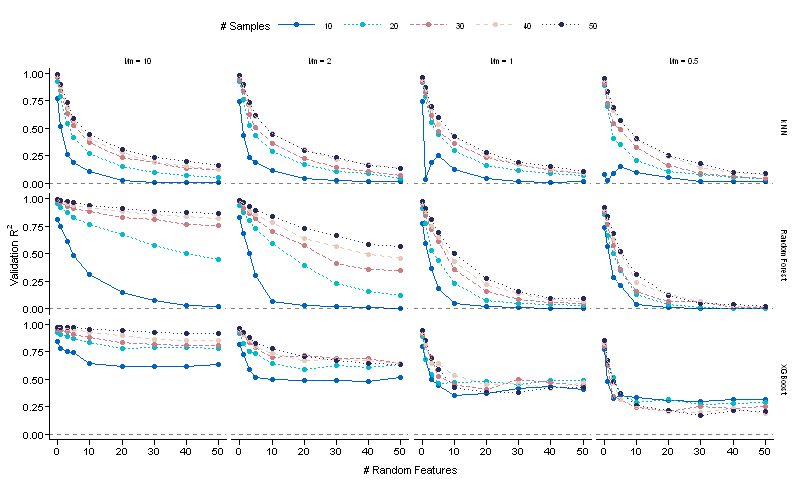

In [582]:
### PLOTS
results_summary <- results %>%
    mutate(n_sub = factor(n_sub), ratio = factor(ratio)) %>%
    group_by(n_sub, n_extra, model, ratio) %>%
    summarize(mu = median(Rsquared), low = quantile(Rsquared, 0.2),
              high = quantile(Rsquared, 0.8))

results_sample <- results %>%
 mutate(n_sub = factor(n_sub)) %>%
 filter(model == "rf", n_sub == 30, ratio == 0.5, repetition == 4)

y_labeller <- c("knn" = "kNN",
            "rf" = "RandomForest",
             "xgb" = "XGBoost")

x_labeller <- c(
             "0.1" = "i/m = 10",
             "0.5" = "i/m = 2",
             "1" = "i/m = 1",
             "2" = "i/m = 0.5")

options(repr.plot.width = 6.6, repr.plot.height = 4)

p <- ggplot(results_summary, aes(x = n_extra)) +

geom_point(aes(y = mu, color = n_sub), size = 1,
 position = position_dodge(width = 0)) +
geom_line(aes(y = mu, color = n_sub, linetype = n_sub)) +
geom_hline(yintercept = 0, linetype = 2, alpha = 0.5) +

facet_grid(model ~ ratio, labeller = labeller(model = y_labeller,
                                                  ratio = x_labeller),
                                                  ) +

theme_prism(base_size = 6.3) +
theme(legend.position = "top", legend.title = element_text(),
      text = element_text(face = "plain", family = "sans")) +
scale_color_manual(values = agd_palette) +

labs(x = "# Random Features",
 y = expression(paste("Validation ", R^2, sep = " ")),
 color = "# Samples", linetype = "# Samples") +
theme(legend.key.width = unit(1.9, "line")) +
theme(strip.text.y = element_text(vjust = 2))

p

ggsave("../doexyF_paper/plots/simulation_B.png",
 p, width = 6.6, height = (4 / 6) * 6.76, dpi = 600)
ggsave("../doexyF_paper/plots/simulation_B.svg",
 p, width = 6.6, height = (4 / 6) * 6.76)


In [583]:
# select an individual point for plotting further
t_i <- tot_tr %>%
 filter(n_sub == 30, ratio == 0.5, repetition == 3, n_extra == 0)
v_i <- tot_val %>%
 filter(n_sub == 30, ratio == 0.5, repetition == 3)

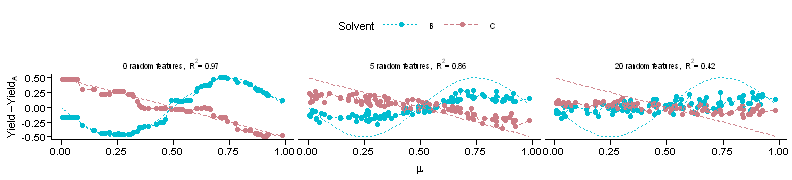

In [584]:
labeller <- c(expression(paste("0 random features,  ", R^2, "= 0.97", sep = " ")),
            "1 random features",
            "3 random features",
            expression(paste("5 random features,  ", R^2, "= 0.86", sep = " ")),
            "10 random features",
            expression(paste("20 random features,  ", R^2, "= 0.42", sep = " ")),
            "30 random features",
            "40 random features",
            "50 random features"
            )

preds <- v_i %>%
    pivot_wider(id_cols = c(var, n_extra), 
    values_from = pred.rf, names_from = cond) %>%
    mutate("B" = B - A, "c-a" = C - A) %>%
    select(var, "B", "C", n_extra) %>%
    pivot_longer(cols = c("B", "C")) %>%
    mutate(n_extra_lab = factor(n_extra,
                            levels = c(0, 1, 3, 5, 10, 20, 30, 40, 50),
                            labels = labeller)
                            )

targets <- v_i %>%
    pivot_wider(id_cols = c(var, n_extra),
     values_from = target, names_from = cond) %>%
    mutate("B" = B - A, "C" = C - A) %>%
    select(var, "B", "C", n_extra) %>%
    pivot_longer(cols = c("B", "C"))

options(repr.plot.width = 6.6, repr.plot.height = 1.5)


p4 <- ggplot(preds %>% filter(n_extra %in% c(0, 5, 20)),
 aes(x = var, y = value, color = name)) +
geom_point(size = 1) +
geom_line(aes(linetype = name)) +
geom_line(data = targets %>% filter(n_extra %in% c(0, 5, 20)),
 aes(x = var, y = value, color = name, linetype = name), alpha = 0.9) +
labs(x = expression(mu), y = expression(Yield - Yield[A]),
     color = "Solvent", linetype = "Solvent") +
facet_wrap(. ~ n_extra_lab, labeller = label_parsed) +
theme_prism(base_size = 6.3) +
theme(legend.position = "top", legend.title = element_text(),
      text = element_text(face = "plain", family = "sans")) +
#theme(panel.spacing = unit(2, "lines")) +
theme(legend.key.width = unit(1.9, "line")) +
scale_color_manual(values = agd_palette[c(2, 3)]) +
scale_linetype_manual(values = linetype_pal()(3)[c(2, 3)])

p4

ggsave("../doexyF_paper/plots/simulation_C.png",
 p4, width = 6.6, height = (1 / 4) * 6.76, dpi = 600)
ggsave("../doexyF_paper/plots/simulation_C.svg",
 p4, width = 6.6, height = (1 / 4) * 6.76)

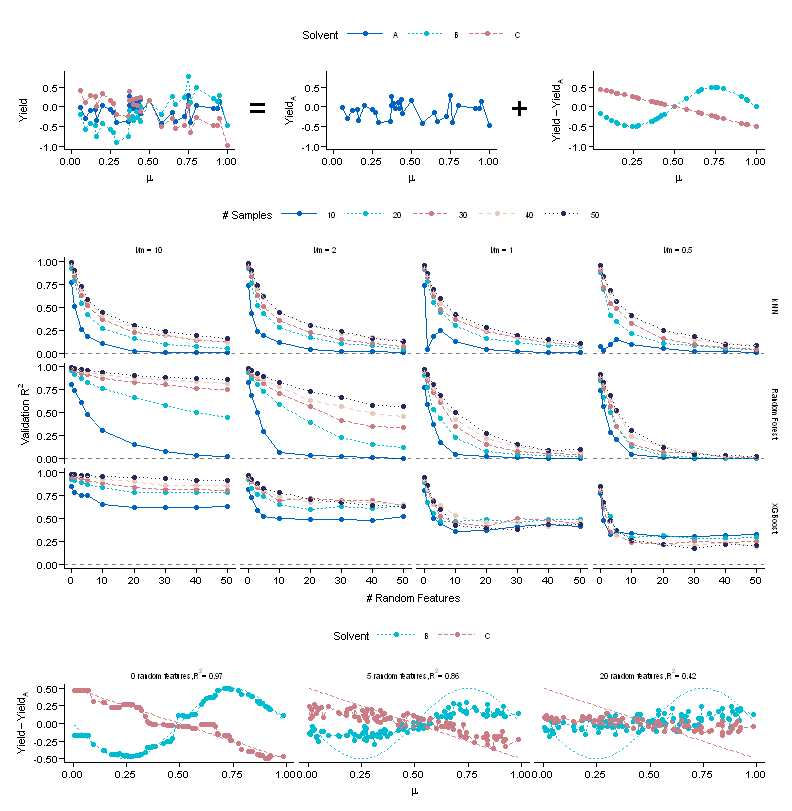

In [579]:
options(repr.plot.width = 6.6, repr.plot.height = 6.76)

pf1 / p / p4 +
plot_layout(heights = c(1, 4, 1))

ggsave("../doexyF_paper/plots/simulation.png",
 width = 6.6, height = 6.76, dpi = 600)
ggsave("../doexyF_paper/plots/simulation.svg",
 width = 6.6, height = 6.76)

Would the $M_1$ modeling methodology find the interaction

In [607]:
library(emmeans)

In [608]:
# make simulated data with 1:1 ratio between main/interaction effects
n_sub <- 30
d <- make_data("2", n_sub, 1, 0, 1) %>%
    mutate(sub = factor(extra_var_1, labels = paste("sub_", 1:n_sub)))

In [627]:
# model the data including and interaction effect
m <- lm(target ~ sub * cond, data = d)

# calculate the differences using contrast on A
sc <- emmeans(m, trt.vs.ctrl ~ cond | sub, ref = "A")

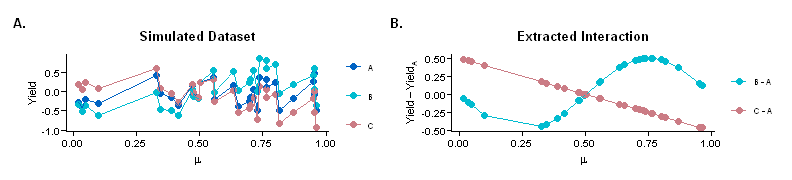

In [636]:
# plot the original data
pv_data <- d %>%
ggplot(aes(x = var, y = target, col = cond)) +
    geom_point() +
    geom_line() +
    scale_color_manual(values = agd_palette) +
    labs(x = expression(mu), y = expression(Yield),
    title = "Simulated Dataset", tag = "A.") +
    theme_prism(base_size = 6.3)


# plot the contrast
pv_ctr <- sc$contrast %>%
    as.data.frame() %>%
    left_join(d %>% select(sub, var) %>% unique(), by = "sub") %>%
ggplot(aes(x = var, y = estimate, col = contrast)) +
    geom_point() +
    geom_line() +
    scale_color_manual(values = agd_palette[c(2, 3)]) +
    labs(x = expression(mu), y = expression(Yield - Yield[A]),
    title = "Extracted Interaction", tag = "B.") +
    theme_prism(base_size = 6.3)

pv_data + pv_ctr